# Курс "Глубокое обучение"
## Задание 1
## "Лучшая CNN-архитектура-2"

***Михеев Борис, 317***


В данной работе проводится сравнение различных CNN-архитектур на датасете CIFAR-10 - коллекции из 60000 цветных изображений размера 32$\times$32, принадлежащих к 10 разным классам. 

Критерии для сравнения сетей:

- Точность классификации на тестовой выборке

- Значение функции потерь на тестовой выборке

- Точность классификации на валидационной выборке во время обучения

- Значение функции потерь на валидационной выборке во время обучения

- Время обучения

- Время предсказания

Эксперименты проводятся при следующих фиксированных параметрах:

- Разбиение данных на обучение/валидацию/тест: 5/1/1, аугментации не применяются

- Размер батча: 128

- Число эпох обучения: 30

- Функция потерь: CrossEntropyLoss

- Метод обучения сети: алгоритм Adam. Параметры: $\gamma=10^{-3}$ (темп обучения константный), $\beta_1=0.9$, $\beta_2=0.999$, $\lambda=0$ 


Используемые реализации архитектур основаны на материале из репозитория: https://github.com/kuangliu/pytorch-cifar

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

Основные функции для загрузки данных, обучения и оценки качества сети:

In [2]:
# Параметры для нормализации
# Источник: https://github.com/kuangliu/pytorch-cifar/issues/19
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.247, 0.2435, 0.2616],
)

In [ ]:
def samplers(n, split_shuffle=True, val_size=0.1):
    if split_shuffle:
        idx = torch.randperm(n, generator=torch.Generator().manual_seed(0))
    else:
        idx = torch.arange(n)
    split_idx = int((1.0 - val_size) * n)
    train_sampler = SubsetRandomSampler(idx[:split_idx])
    val_sampler = SubsetRandomSampler(idx[split_idx:])
    return train_sampler, val_sampler

In [ ]:
def train_val_dataloader(root_dir='./cifar10', split_shuffle=True, val_size=0.1, batch_size=128):
    train_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    val_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))

    
    train_sampler, val_sampler = samplers(len(train_dataset), split_shuffle, val_size)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)
    return train_dataloader, val_dataloader


In [ ]:
def test_dataloader(root_dir='./cifar10', batch_size=128):
    test_dataset = CIFAR10(root=root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    return test_dataloader

In [ ]:
def train_batch(model, x_batch, y_batch, loss_fn, optimizer):
    model.train()
    model.zero_grad()
    output = model(x_batch)
    loss = loss_fn(output, y_batch)
    loss.backward()
    optimizer.step()
    batch_loss = loss.cpu().item()
    with torch.no_grad():
        batch_acc_sum = (output.argmax(dim=1) == y_batch).sum().cpu().item()
    return batch_loss, batch_acc_sum


In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    epoch_loss = 0.0
    epoch_acc = 0
    epoch_size = 0
    for i_batch, (X_batch, y_batch) in enumerate(dataloader):
        batch_loss, batch_acc_sum = train_batch(model, X_batch.to(model.device), y_batch.to(model.device), loss_fn, optimizer)
        epoch_size += len(X_batch)
        epoch_loss += batch_loss * len(X_batch)
        epoch_acc += batch_acc_sum
    epoch_loss /= epoch_size
    epoch_acc /= epoch_size
    return epoch_loss, epoch_acc


In [ ]:
def train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs, callback=None):
    epochs = tqdm(range(n_epochs), desc='Epochs', leave=True)
    for i_epoch in epochs:
        epoch_loss, epoch_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
        if callback is not None:
            cb_dict = callback(model, val_dataloader, loss_fn, epoch_loss, epoch_acc)
            epochs.set_postfix(cb_dict)

In [ ]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch.to(model.device)).cpu()
            logits.append(output)
            targets.append(y_batch)
    logits = torch.cat(logits)
    targets = torch.cat(targets)
    loss = loss_fn(logits, targets).item()
    acc = (logits.argmax(dim=1) == targets).sum().item() / len(targets)
    return loss, acc


In [ ]:
class CallBack:
    def __init__(self, eval_fn, name=None):
        self.eval_fn = eval_fn
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
    
    def last_info(self):
        return {'loss_train': f'{self.train_losses[-1]}',
                'acc_train': f'{self.train_accs[-1]}',
                'loss_val': f'{self.val_losses[-1]}',
                'acc_val': f'{self.val_accs[-1]}'}

    def __call__(self, model, val_dataloader, loss_fn,
                 epoch_loss=None, epoch_acc=None):
        self.train_losses.append(epoch_loss)
        self.train_accs.append(epoch_acc)
        loss_val, acc_val = self.eval_fn(model, val_dataloader, loss_fn)
        self.val_losses.append(loss_val)
        self.val_accs.append(acc_val)
        return self.last_info()

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

Загрузка данных:

In [ ]:
train_dataloader, val_dataloader = train_val_dataloader()
test_loader = test_dataloader()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device

device(type='cuda')

Перейдем к рассмотрению архитектур.

# LeNet

Одна из первых и простейших сверточных архитектур. Состоит из 2 сверточных слоев (свертка с ядром 5$\times$5, пулинг, активация) для извлечения признаков и 3 полносвязных слоев для классификации. В качестве пулинга применяется average pooling, в качестве функции активации - гиперболический тангенс.  

In [5]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.tanh(self.conv1(x))
        out = F.avg_pool2d(out, 2)
        out = F.tanh(self.conv2(out))
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.tanh(self.fc1(out))
        out = F.tanh(self.fc2(out))
        out = self.fc3(out)
        return out 

LeNet имеет небольшое число параметров, наименьшее среди всех рассматриваемых архитектур.

In [6]:
count_parameters(LeNet())

62006

In [ ]:
%%time
model = LeNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


CPU times: user 8min 10s, sys: 3.47 s, total: 8min 14s
Wall time: 8min 23s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'LeNet, test loss: {loss}')
print(f'LeNet, test accuracy: {acc}')

LeNet, test loss: 1.4857083559036255
LeNet, test accuracy: 0.5529
CPU times: user 2.77 s, sys: 1.97 ms, total: 2.77 s
Wall time: 2.77 s


Сеть быстро обучается и выдает прогноз. Однако качество на тесте крайне низкое.

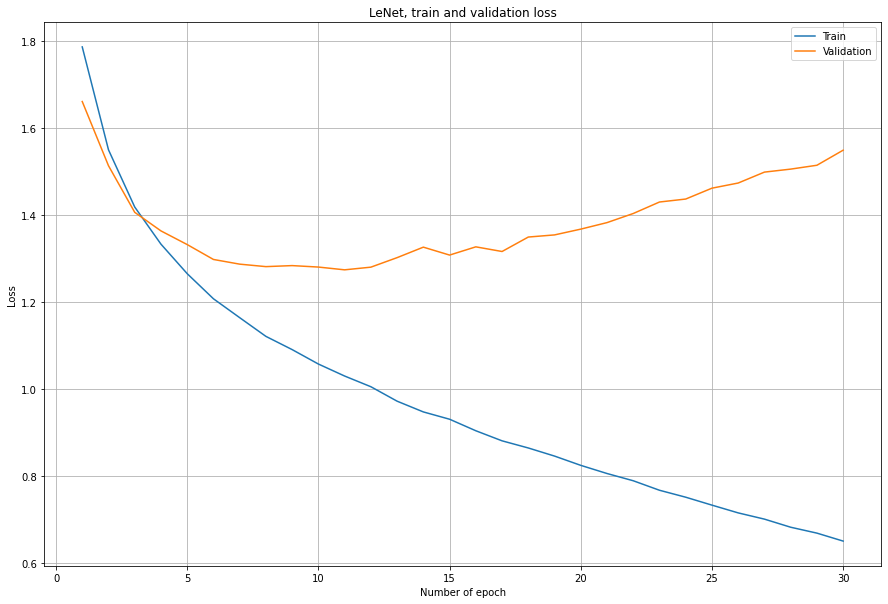

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('LeNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.6495977681371901, on 30 epoch
Best loss on validation: 1.273067831993103, on 11 epoch


Функция потерь принимает достаточно большие значения. На обучении она убывает очень медленно, на валидации начинает заметно расти уже после 10 эпохи. 

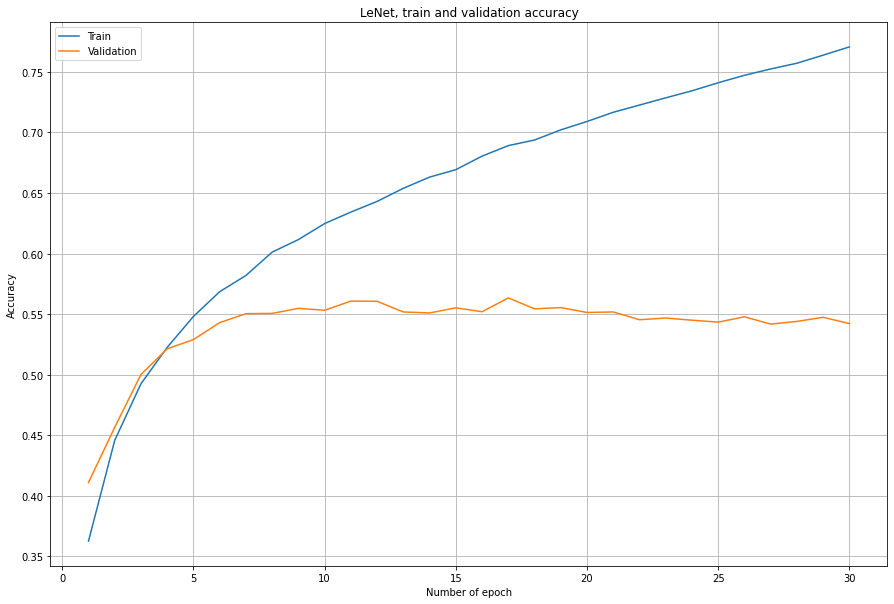

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('LeNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.7706444444444445, on 30 epoch
Best accuracy on validation: 0.5634, on 17 epoch


Точность на обучающей выборке растет так же медленно, оставаясь ниже 0.8. На валидационных данных она перестает расти после 10 эпохи и колеблется около 0.55, наблюдается небольшой спад на последних эпохах.

Результаты LeNet неудовлетворительные, сеть плохо обучилась и показала крайне низкую точность на тесте. Вероятно, причинами этого послужили простота архитектуры в целом, использование гиперболического тангенса в качестве активации и, как следствие, проблема возможного затухания градиентов и медленное обучение. При экспериментах с другим выбором темпа обучения и оптимизатора результаты были хуже или примерно такими же.

# AlexNet

Данная архитектура по сути является модификацией LeNet. Увеличился размер сети (возрасла размерность признаковых пространств в полносвязных слоях), гиперболический тангенс был заменен на ReLU, что позволило бороться с затуханием градиентов, снизить время вычисления функции активации и ускорить обучение в целом. Вместо average pooling применяется max pooling. Также перед первым и вторым полносвязным слоем применяются слои дропаута для борьбы с переобучением. В отличие от LeNet есть применение нескольких сверток подряд, без пулингов между ними. Однако сильно увеличилось число параметров в полносвязной части.

In [7]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [8]:
count_parameters(AlexNet())

23272266

In [ ]:
%%time
model = AlexNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 10min 10s, sys: 1.86 s, total: 10min 12s
Wall time: 10min 18s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'AlexNet, test loss: {loss}')
print(f'AlexNet, test accuracy: {acc}')

AlexNet, test loss: 1.710699439048767
AlexNet, test accuracy: 0.6978
CPU times: user 3.08 s, sys: 2 ms, total: 3.08 s
Wall time: 3.08 s


Время обучения и предсказания сравнимы с LeNet, несмотря на возросшие размеры архитектуры. Точность на тесте увеличилась, однако по-прежнему осталась невысокой. Потери немного больше, чем у LeNet.

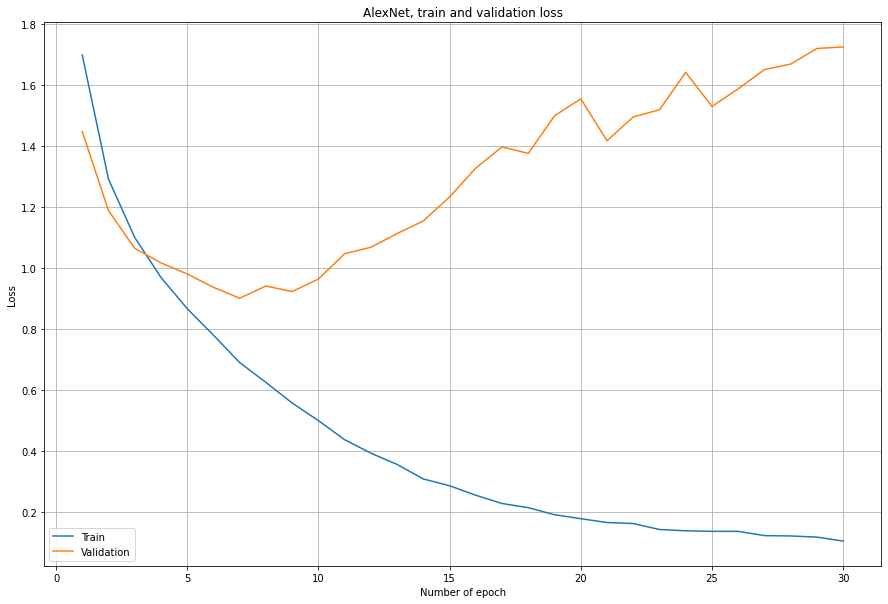

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('AlexNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.10551359682083129, on 30 epoch
Best loss on validation: 0.9020830988883972, on 7 epoch


AlexNet стала обучаться быстрее, однако функция потерь на валидации все так же начинает довольно быстро расти уже на 10 эпохе. Заметен эффект переобучения.

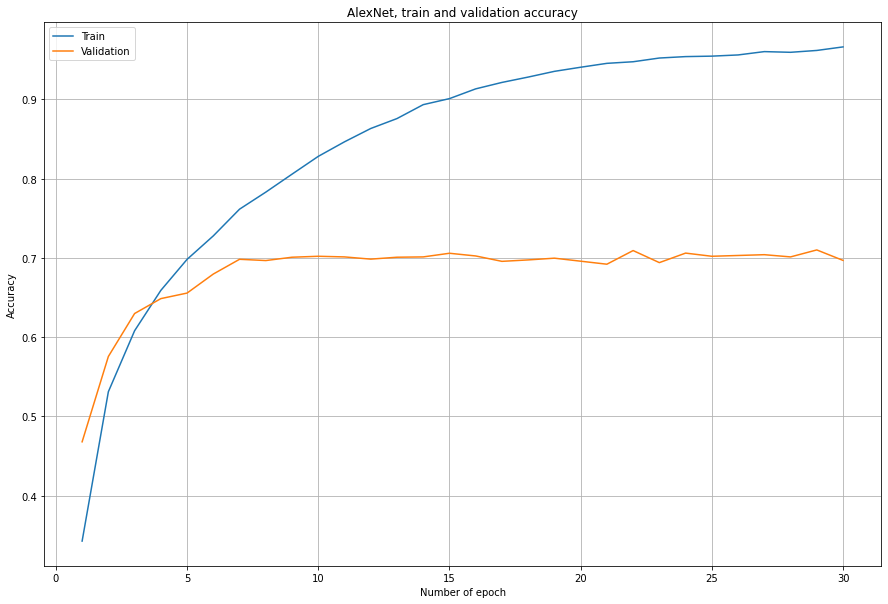

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('AlexNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9660444444444445, on 30 epoch
Best accuracy on validation: 0.71, on 29 epoch


Достигается высокое качество на обучающих данных, на валидационных значение точности стабилизируется в районе 0.7 примерно с 7 эпохи, осциллирует не сильно и довольно медленно падает к концу обучения. 

В сравнении с LeNet AlexNet достигает лучших результатов, ускорилось обучение и повысилось качество. Однако точность все равно остается невысокой, и присутствует эффект переобучения.

# VGG

Является развитием идеи AlexNet. VGG использует каскад сверток с ядром 3$\times$3 вместо больших сверток. Это позволяет расширить рецептивные поля нейронов, сократить число параметров и повысить число нелинейностей. Функция активации - ReLU, используется после каждого сверточного и полносвязного слоя.  Размер архитектуры довольно большой, но ее реализация относительно проста. Существует несколько конфигураций данной архитектуры, отличающихся числом последовательных сверток 3$\times$3. 

Рассмотрим несколько архитектур из данного семейства, отличающихся числом слоев: VGG11, VGG13, VGG16, VGG19. Используемая реализация отличается от классической: в части классификатора используется лишь один линейный слой вместо двух, а также используется батч-нормализация.

In [12]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11():
    return VGG('VGG11')


def VGG13():
    return VGG('VGG13')


def VGG16():
    return VGG('VGG16')


def VGG19():
    return VGG('VGG19')

**VGG11**

In [13]:
count_parameters(VGG11())

9231114

In [ ]:
%%time
model = VGG11()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 9min 40s, sys: 2.55 s, total: 9min 42s
Wall time: 9min 51s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'VGG11, test loss: {loss}')
print(f'VGG11, test accuracy: {acc}')

VGG11, test loss: 1.0174319744110107
VGG11, test accuracy: 0.8216
CPU times: user 2.54 s, sys: 2.98 ms, total: 2.54 s
Wall time: 2.54 s


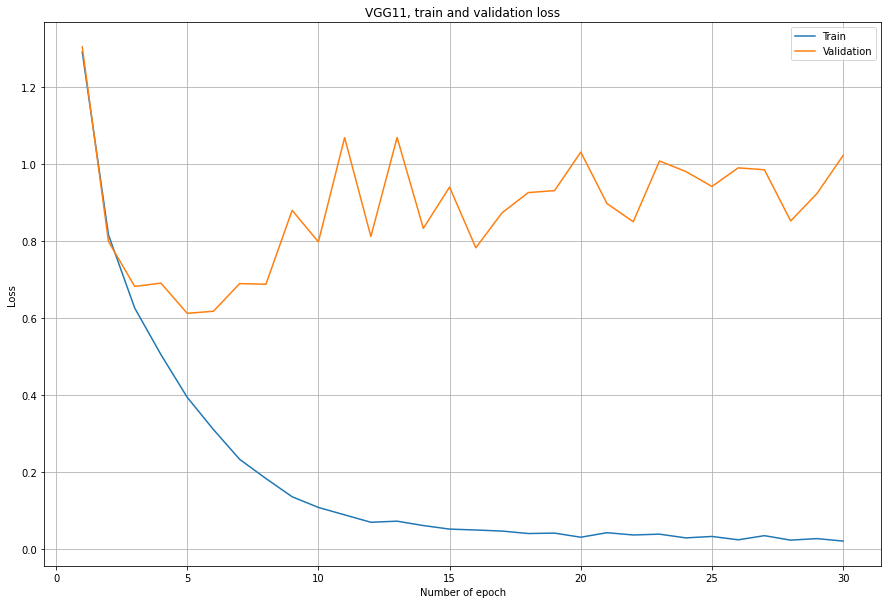

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('VGG11, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.02102117877867487, on 30 epoch
Best loss on validation: 0.6118584275245667, on 5 epoch


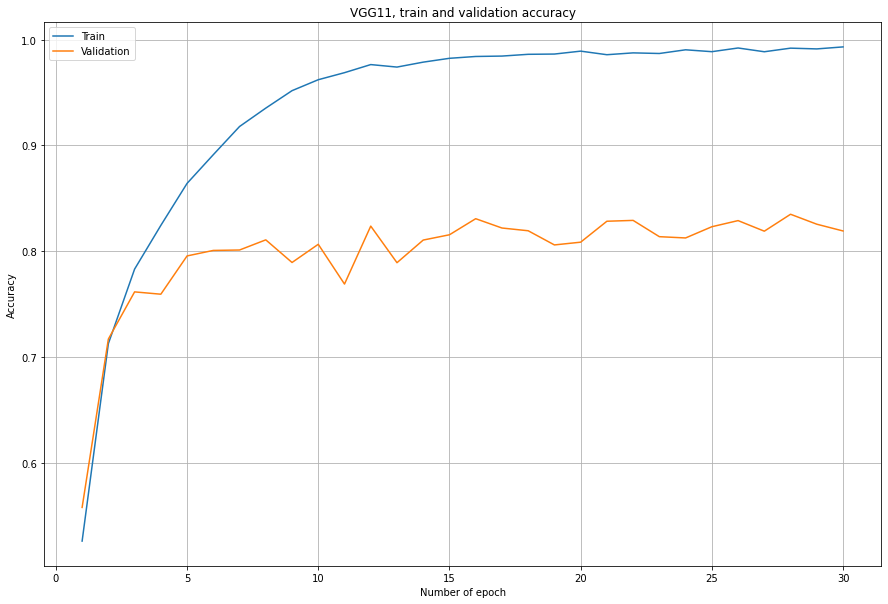

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('VGG11, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9930444444444444, on 30 epoch
Best accuracy on validation: 0.8348, on 28 epoch


**VGG13**

In [14]:
count_parameters(VGG13())

9416010

In [ ]:
%%time
model = VGG13()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 12min 24s, sys: 1.3 s, total: 12min 26s
Wall time: 12min 28s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'VGG13, test loss: {loss}')
print(f'VGG13, test accuracy: {acc}')

VGG13, test loss: 0.8276071548461914
VGG13, test accuracy: 0.8437
CPU times: user 2.85 s, sys: 998 µs, total: 2.85 s
Wall time: 2.85 s


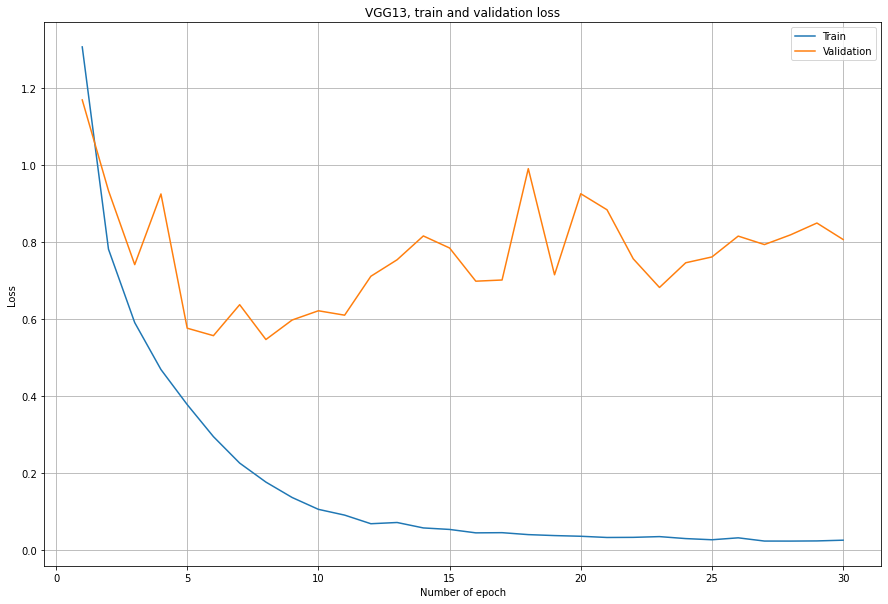

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('VGG13, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.024336573348442712, on 28 epoch
Best loss on validation: 0.5470611453056335, on 8 epoch


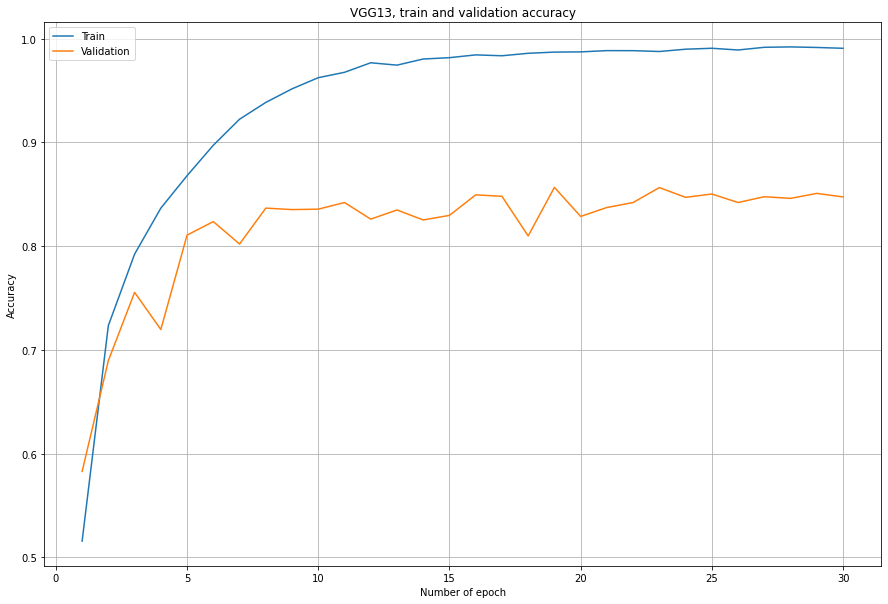

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('VGG13, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.992, on 28 epoch
Best accuracy on validation: 0.8566, on 19 epoch


**VGG16**

In [15]:
count_parameters(VGG16())

14728266

In [ ]:
%%time
model = VGG16()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 13min 46s, sys: 1.29 s, total: 13min 47s
Wall time: 13min 50s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'VGG16, test loss: {loss}')
print(f'VGG16, test accuracy: {acc}')

VGG16, test loss: 0.7085756063461304
VGG16, test accuracy: 0.8575
CPU times: user 3.15 s, sys: 0 ns, total: 3.15 s
Wall time: 3.15 s


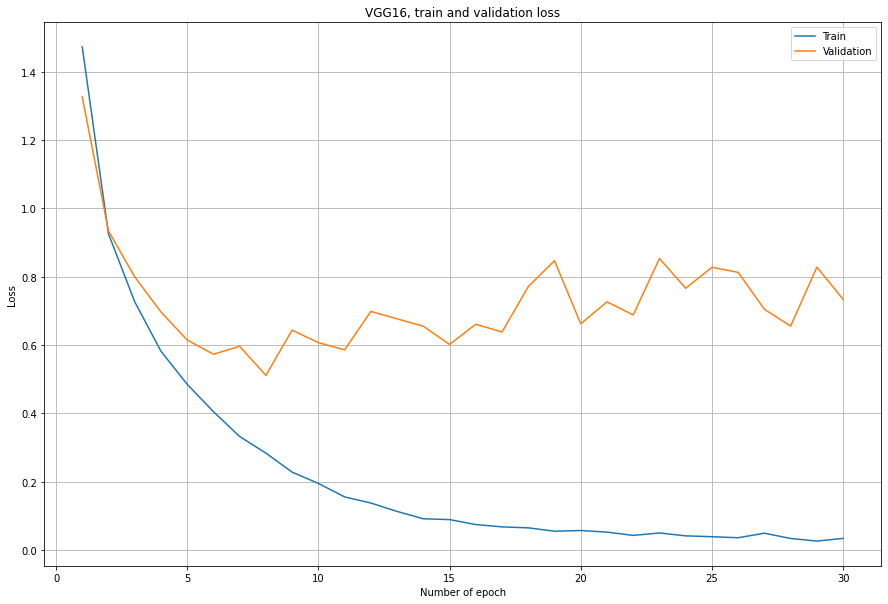

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('VGG16, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.025542302821576594, on 29 epoch
Best loss on validation: 0.5108439922332764, on 8 epoch


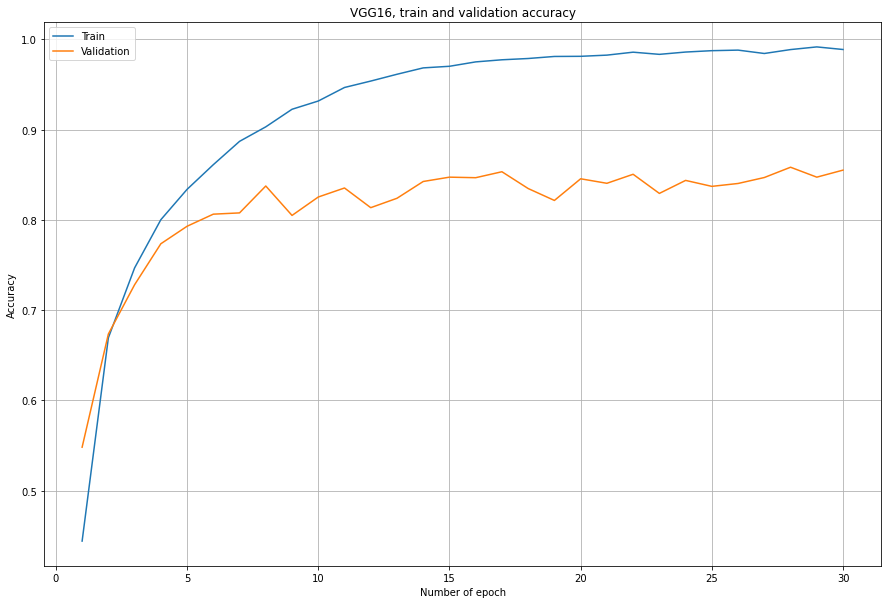

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('VGG16, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9917111111111111, on 29 epoch
Best accuracy on validation: 0.8584, on 28 epoch


**VGG19**

In [17]:
count_parameters(VGG19())

20040522

In [ ]:
%%time
model = VGG19()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 16min 58s, sys: 2.13 s, total: 17min 1s
Wall time: 17min 5s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'VGG19, test loss: {loss}')
print(f'VGG19, test accuracy: {acc}')

VGG19, test loss: 0.7765334248542786
VGG19, test accuracy: 0.8493
CPU times: user 4.12 s, sys: 4.01 ms, total: 4.12 s
Wall time: 4.12 s


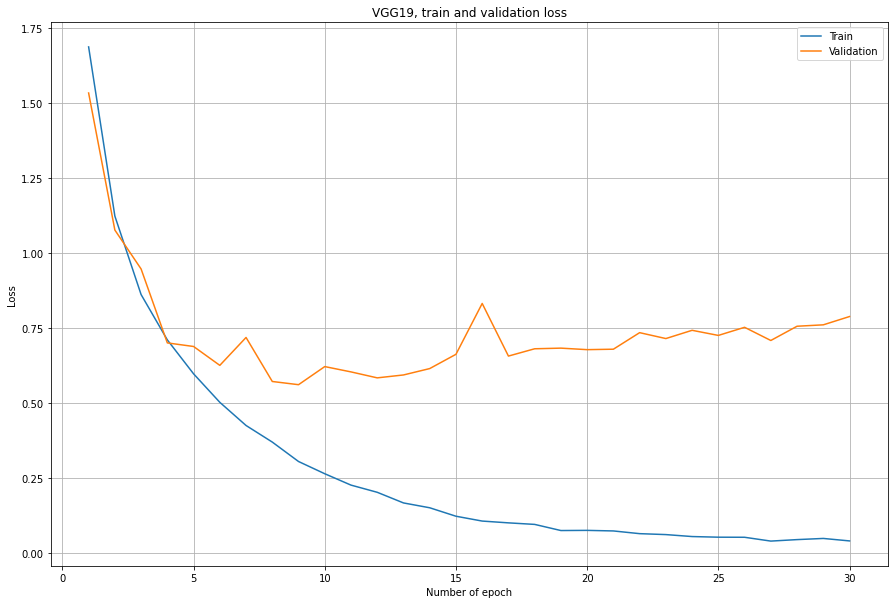

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('VGG19, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.04085821648306317, on 27 epoch
Best loss on validation: 0.5616485476493835, on 9 epoch


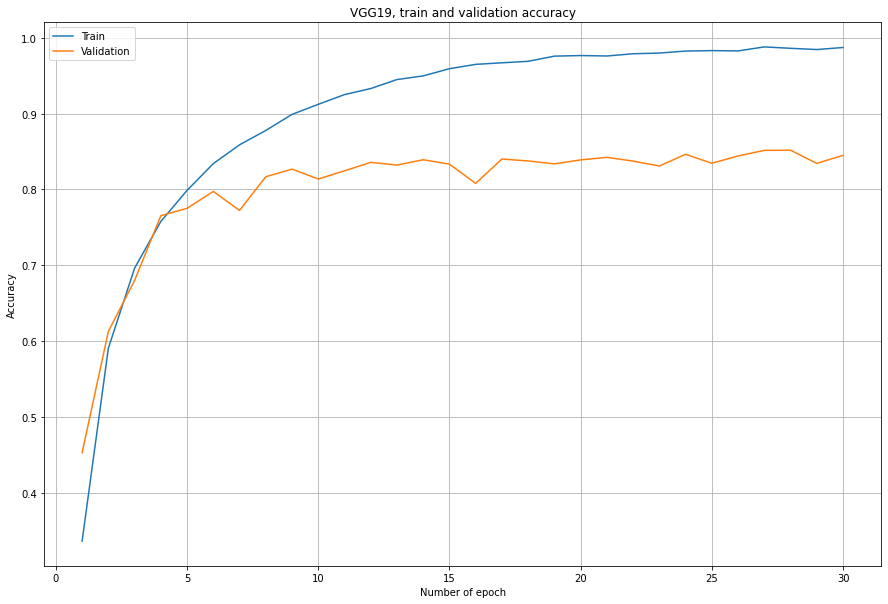

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('VGG19, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9878444444444444, on 27 epoch
Best accuracy on validation: 0.8516, on 28 epoch


В целом рассмотренные сети достигают высокой точности на тестовой выборке и достаточно быстро обучаются. Графики функции потерь на валидации достаточно нестабильны, однако с увеличением числа слоев они сглаживаются. То же самое можно сказать и про точность на валидации. Сильного переобучения не заметно. Результаты для рассмотренных 4 моделей близки, наилучшие имеет VGG16. 

Сети VGG значительно превосходят LeNet и AlexNet, достигают высокого качества и во многом избегают переобучения. Этому способствует увеличение числа слоев, применение каскада сверток, дропаута и батч-нормализации (в использованной реализации). 

# GoogLeNet

Основным нововведением данной архитектуры стало использование модулей Inception, в которых данные по сути могут идти по нескольким параллельным путям, и соответсвующие выходы затем конкатенируются. Это позволяет сети пропускать сигнал через блоки во время обучения максимально эффективным образом, и в итоге более важные пути станут вносить больший вклад в результат. В параллельных ветвях используются свертки разных размеров, что дает возможность извлекать признаки разного масштаба на каждом уровне. Другая важная применяемая идея - использование сверток 1$\times$1, т. е. по сути линейной комбинации карт признаков. Часто эти карты коррелированы между собой, и применение таких сверток позволяет эффективно уменьшить число каналов при сохранении пространственных размеров изображения. Также данный прием существенно сокращает число параметров. В GoogLeNet вместо полносвязных слоев в конце используется global average pooling и один линейный слой. Для регуляризации используются слои батч-нормализации. Архитектура имеет блочное устройство: сначала используются обычные слои для извлечения признаков, а затем располагается последовательность модулей Inception. Однако сеть имеет большую глубину.

In [18]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

Число параметров сети значительно сократилось.

In [19]:
count_parameters(GoogLeNet())

6166250

In [ ]:
%%time
model = GoogLeNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 52min 55s, sys: 19min 22s, total: 1h 12min 17s
Wall time: 1h 12min 44s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'GoogleNet, test loss: {loss}')
print(f'GoogleNet, test accuracy: {acc}')

GoogleNet, test loss: 0.806978166103363
GoogleNet, test accuracy: 0.8427
CPU times: user 12 s, sys: 44.8 ms, total: 12.1 s
Wall time: 12.4 s


Результаты сравнимы с VGG16 и VGG19, точность на тесте чуть ниже, потери - немного выше. Время обучения и построения прогноза значительно возросло несмотря на меньшее число параметров. Причинами этого могут являться большая глубина сети или порядок предъявления данных во время обучения.

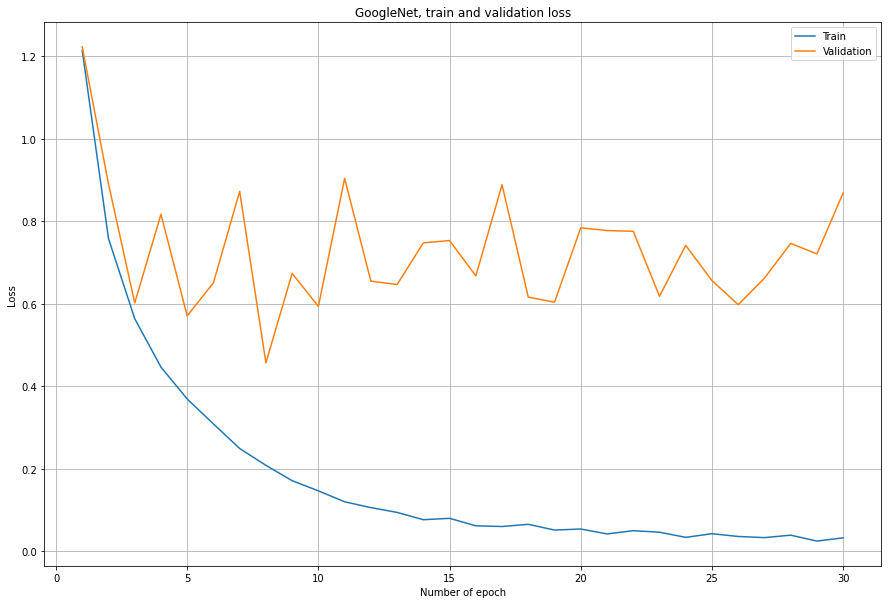

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('GoogleNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.024205598954276906, on 29 epoch
Best loss on validation: 0.45666250586509705, on 8 epoch


Значения функции потерь на обучении довольно низкие, на валидации они быстро достигают низких значений, но начинают сильно колебаться уже после 3 эпохи. К концу обучения график немного сглаживается. 

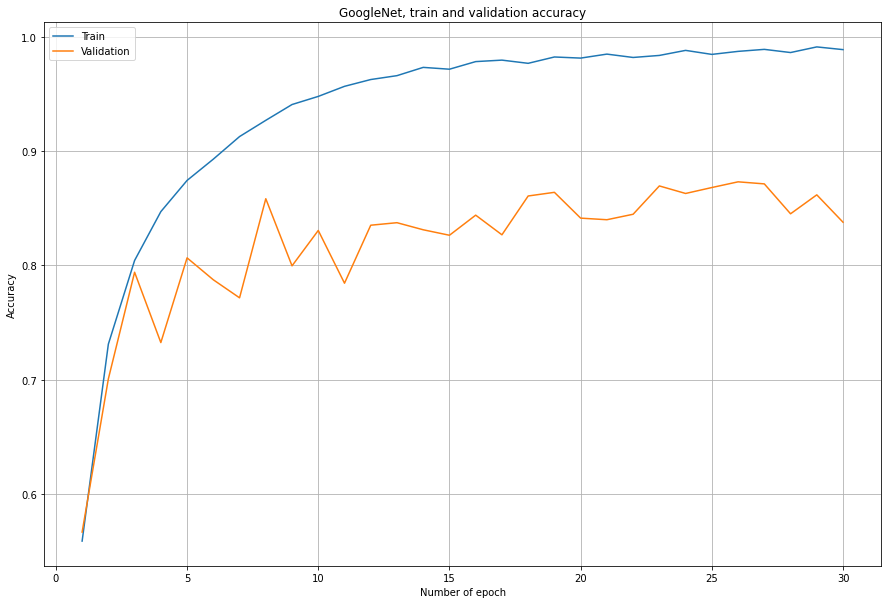

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('GoogleNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9913777777777778, on 29 epoch
Best accuracy on validation: 0.8732, on 26 epoch


График точности сильно колеблется, но с ростом номера эпохи стабилизируется. В целом наблюдается тенденция роста точности, и почти все время она выше 0.8.

GoogLeNet продемонстрировала высокие результаты, незначительно уступающие VGG. Качество достаточно высокое, но при этом время работы сети возросло.

# ResNet

Ключевая идея архитектуры ResNet - пробрасывание связей: данные дополнительно пропускаются параллельно некоторому модулю через тождественный слой и суммируются с выходом модуля. Это приводит к ускорению распространения сигнала по сети, позволяет бороться с обнулением производных и эффективно обучать сети с большим числом слоев. Также применение прокидывания связей меняет поверхность оптимизируемой функции потерь, делает ее более гладкой, с меньшим числом локальных минимумов. В некотором смысле архитектура ResNet схожа с ансамблем моделей, т. к. сеть имеет множество различных путей от входа до выхода, и экспериментально было показано, что они не сильно зависят друг от друга. В глубоких версиях ResNet применялась техника bottleneck для уменьшения количества параметров: понижение числа каналов перед сверточным слоем и последующий возврат к исходному состоянию. Для изменения размерности применяются свертки 1$\times$1. 

Из данного семейства рассмотрим ResNet18, ResNet34, ResNet50, ResNet101.

In [16]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

**ResNet18**

In [17]:
count_parameters(ResNet18())

11173962

In [ ]:
%%time
model = ResNet18()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 21min 42s, sys: 1.76 s, total: 21min 44s
Wall time: 21min 50s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'ResNet18, test loss: {loss}')
print(f'ResNet18, test accuracy: {acc}')

ResNet18, test loss: 1.0460281372070312
ResNet18, test accuracy: 0.823
CPU times: user 4.21 s, sys: 4.99 ms, total: 4.22 s
Wall time: 4.24 s


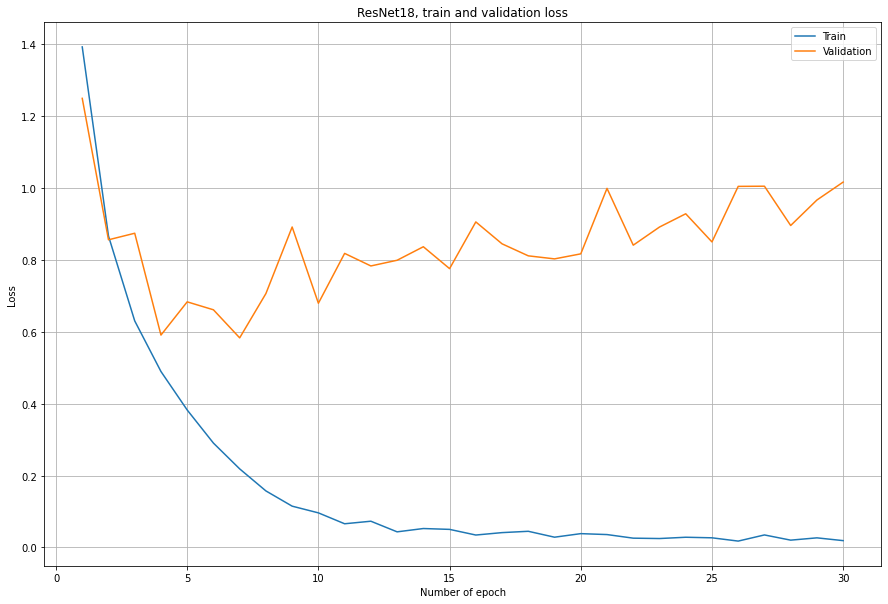

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet18, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.017706028454916346, on 26 epoch
Best loss on validation: 0.582700252532959, on 7 epoch


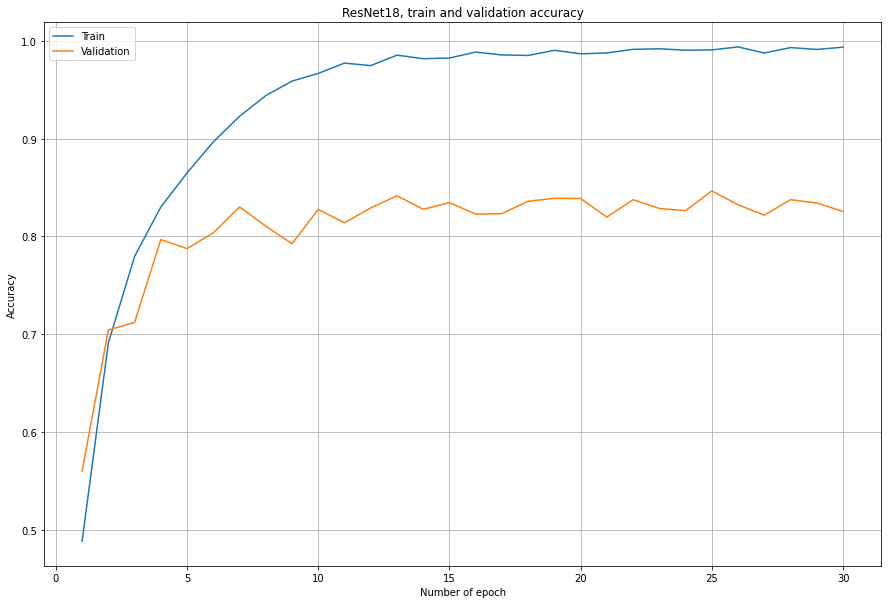

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet18, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9937777777777778, on 26 epoch
Best accuracy on validation: 0.8466, on 25 epoch


**ResNet34**

In [18]:
count_parameters(ResNet34())

21282122

In [ ]:
%%time
model = ResNet34()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 27min 55s, sys: 4min 56s, total: 32min 52s
Wall time: 32min 58s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'ResNet34, test loss: {loss}')
print(f'ResNet34, test accuracy: {acc}')

ResNet34, test loss: 0.8527028560638428
ResNet34, test accuracy: 0.8373
CPU times: user 5.83 s, sys: 2.65 ms, total: 5.83 s
Wall time: 5.85 s


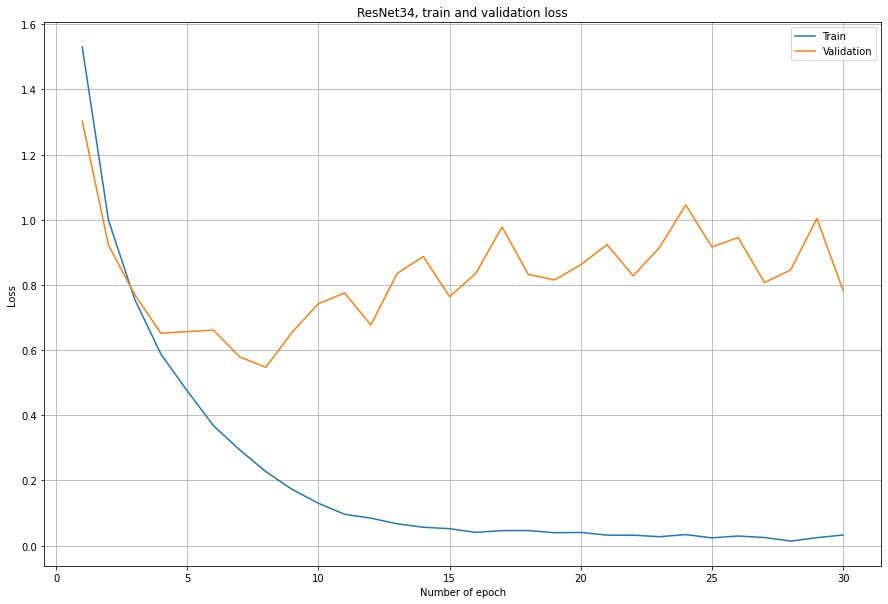

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet34, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.013658928259379335, on 28 epoch
Best loss on validation: 0.5472573637962341, on 8 epoch


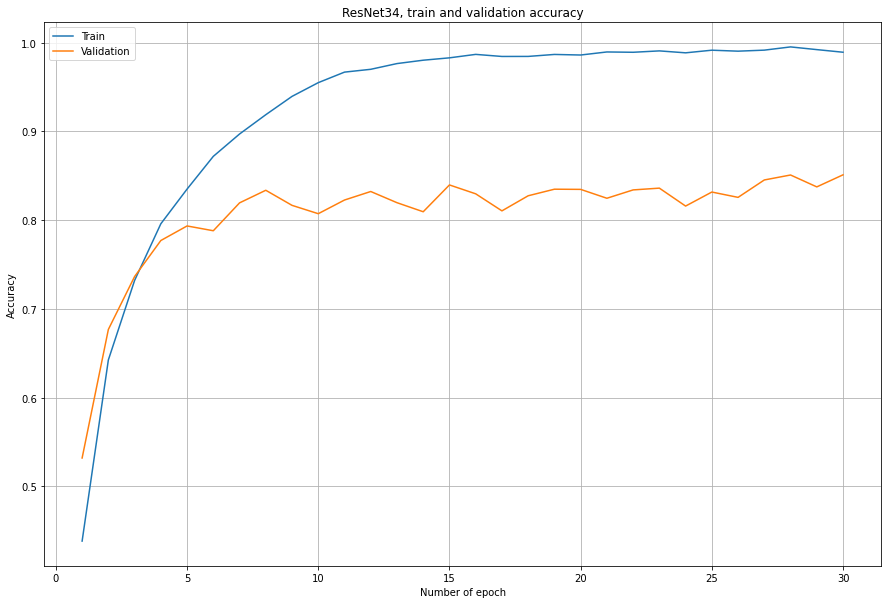

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet34, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9950888888888889, on 28 epoch
Best accuracy on validation: 0.851, on 30 epoch


**ResNet50**

In [24]:
count_parameters(ResNet50())

23520842

In [ ]:
%%time
model = ResNet50()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 39min 47s, sys: 14min 18s, total: 54min 6s
Wall time: 54min 25s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'ResNet50, test loss: {loss}')
print(f'ResNet50, test accuracy: {acc}')

ResNet50, test loss: 0.8021301627159119
ResNet50, test accuracy: 0.8383
CPU times: user 9.21 s, sys: 12.2 ms, total: 9.22 s
Wall time: 9.25 s


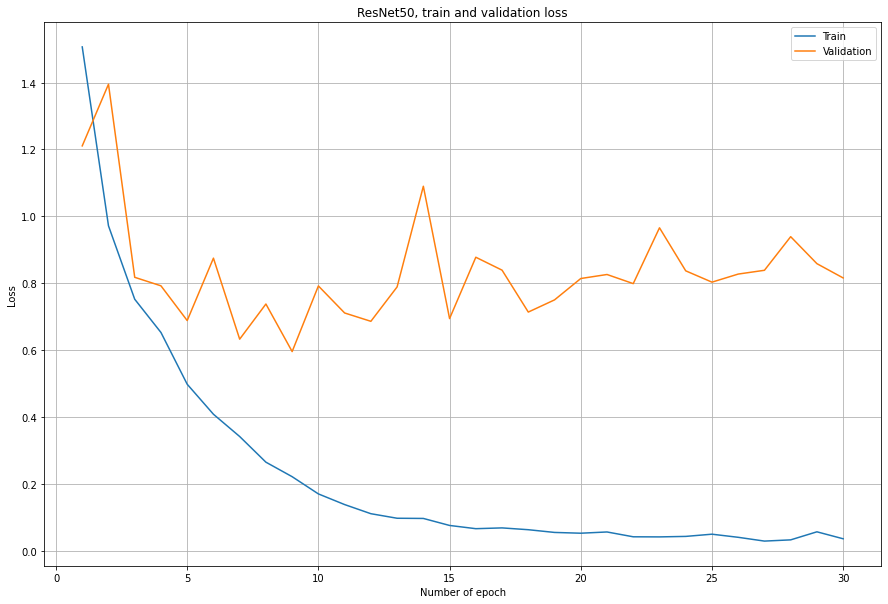

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.029590584387050735, on 27 epoch
Best loss on validation: 0.5959810614585876, on 9 epoch


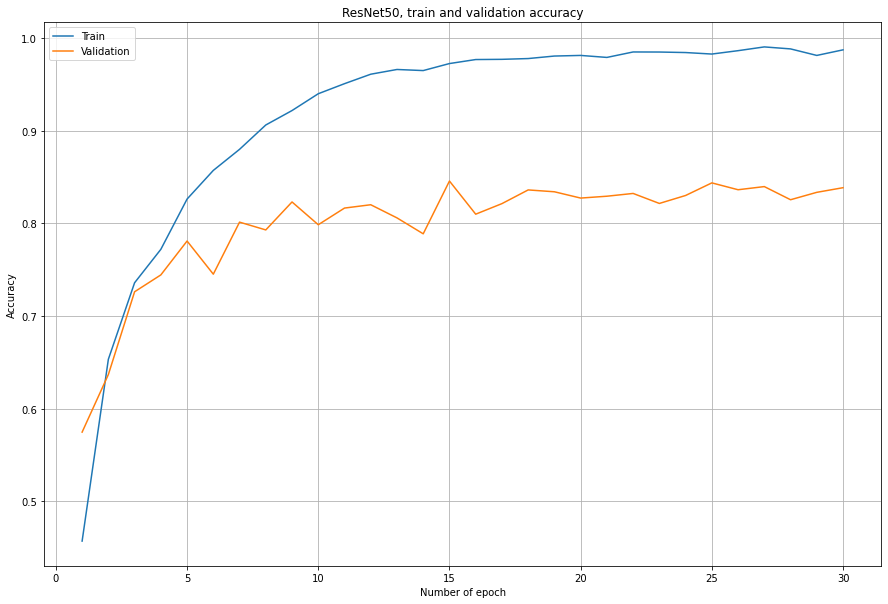

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9906666666666667, on 27 epoch
Best accuracy on validation: 0.8458, on 15 epoch


**ResNet101**

In [19]:
count_parameters(ResNet101())

42512970

In [ ]:
%%time
model = ResNet101()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 52min 42s, sys: 23min 53s, total: 1h 16min 36s
Wall time: 1h 16min 58s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'ResNet101, test loss: {loss}')
print(f'ResNet101, test accuracy: {acc}')

ResNet101, test loss: 0.8652761578559875
ResNet101, test accuracy: 0.8211
CPU times: user 11.6 s, sys: 4.35 ms, total: 11.6 s
Wall time: 11.6 s


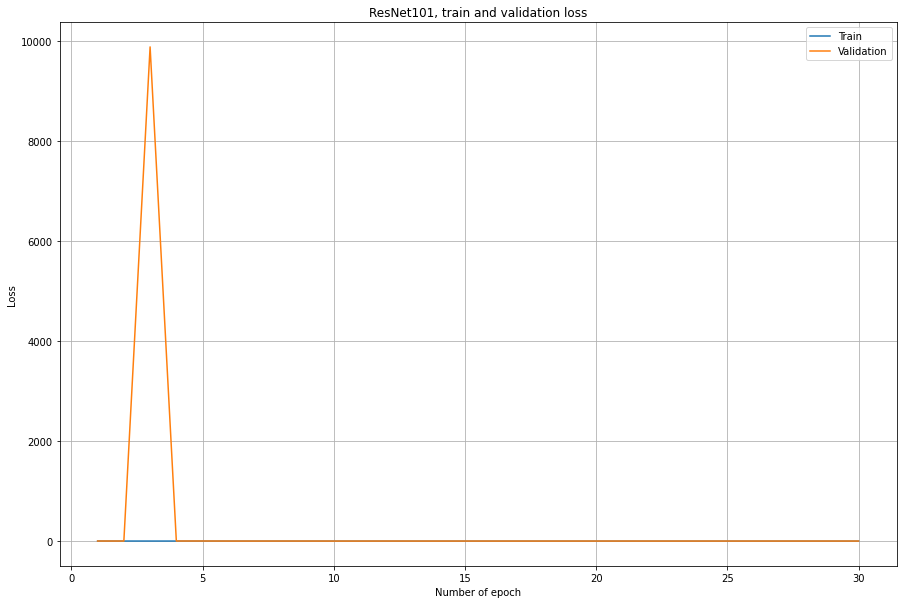

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet101, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

Стоит отметить, что подобный график функции потерь для ResNet101 получался неоднократно в ходе экспериментов. Оставим его как артефакт.

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.027984170075505972, on 27 epoch
Best loss on validation: 0.5452449917793274, on 10 epoch


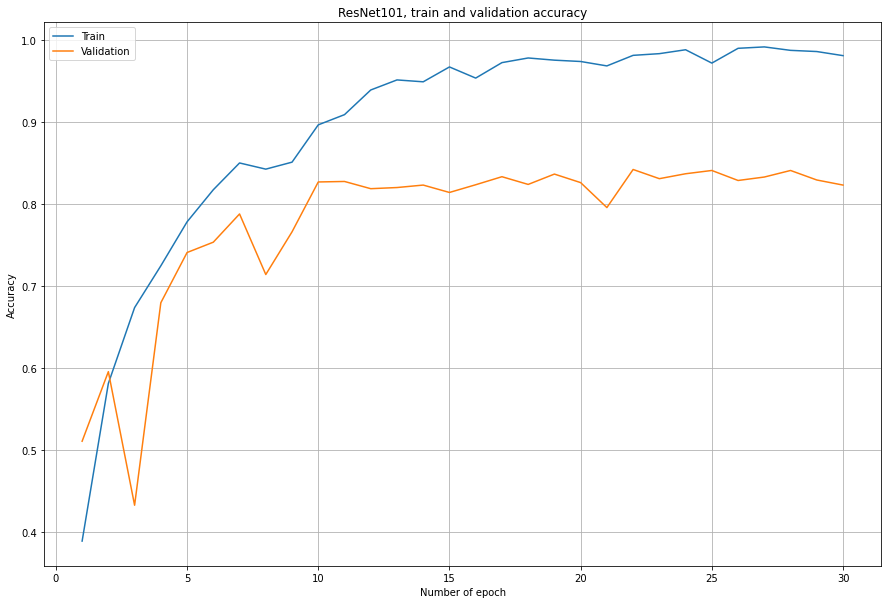

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ResNet101, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.991, on 27 epoch
Best accuracy on validation: 0.8416, on 22 epoch


Модели семейства ResNet имеют высокую итоговую точность, но при этом дольше обучаются из-за возросшей глубины. Также наблюдается нестабильное поведение потерь и точности на валидации, можно заметить эффект переобучения.

# DenseNet

Является развитием идеи ResNet. Основной принцип - проведение всех попарных связей между слоями, являющимися комбинациями блоков батч-нормализации и сверток. Предыдущие входы конкатенируются в один тензор и подаются в следующий слой. Таким образом, число признаков, обрабатываемых в слое, растет линейно, и это позволяет уменьшить количество параметров. Каждый слой получает уже обработанную информацию от всех предыдущих, полезные признаки как бы накапливаются за прямой проход. В итоге улучшается информационный поток по сети. Пробрасывание промежуточных связей происходит не по всей архитектуре, а т. н.  Dense-блоками из наборов попарно связанных между собой слоев. Между блоками применяется пулинг и свертки 1$\times$1 в целях снижения размерности. Также большее число проброшенных связей делает поверхность функции потерь еще более гладкой, чем у ResNet.

In [29]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

In [31]:
count_parameters(DenseNet121())

6956298

Число параметров значительно меньше, чем, например, у ResNet50.

In [ ]:
%%time
model = DenseNet121()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 51min 47s, sys: 13min 31s, total: 1h 5min 18s
Wall time: 1h 5min 36s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'DenseNet, test loss: {loss}')
print(f'DenseNet, test accuracy: {acc}')

DenseNet, test loss: 0.6323034167289734
DenseNet, test accuracy: 0.8775
CPU times: user 10.1 s, sys: 18.5 ms, total: 10.1 s
Wall time: 10.2 s


DenseNet достаточно долго обучается, но у нее наилучшее качество на тесте среди рассмотренных архитектур. 

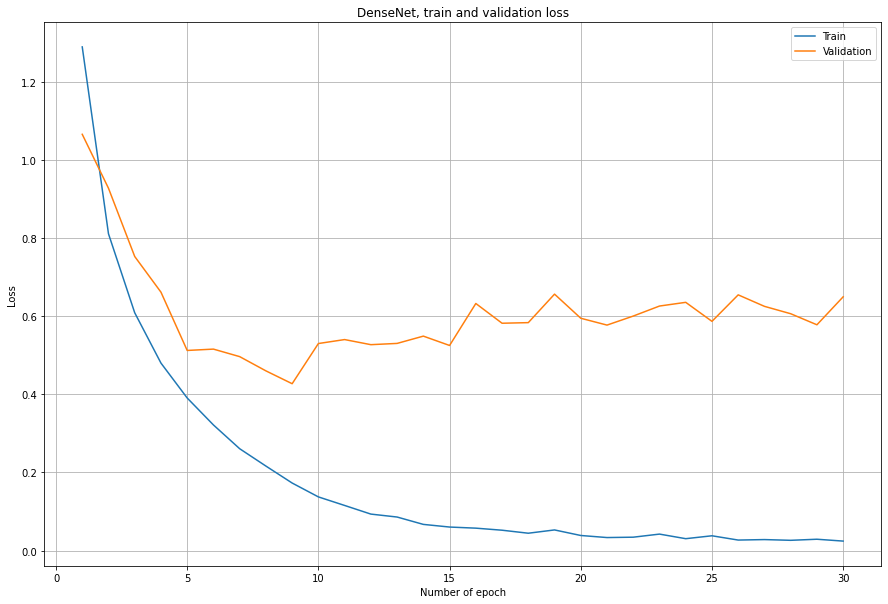

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('DenseNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.024330448770895602, on 30 epoch
Best loss on validation: 0.4272671937942505, on 9 epoch


Значения функции потерь ниже, чем у ResNet, график для валидации значительно более гладкий, есть небольшой рост на последних эпохах.

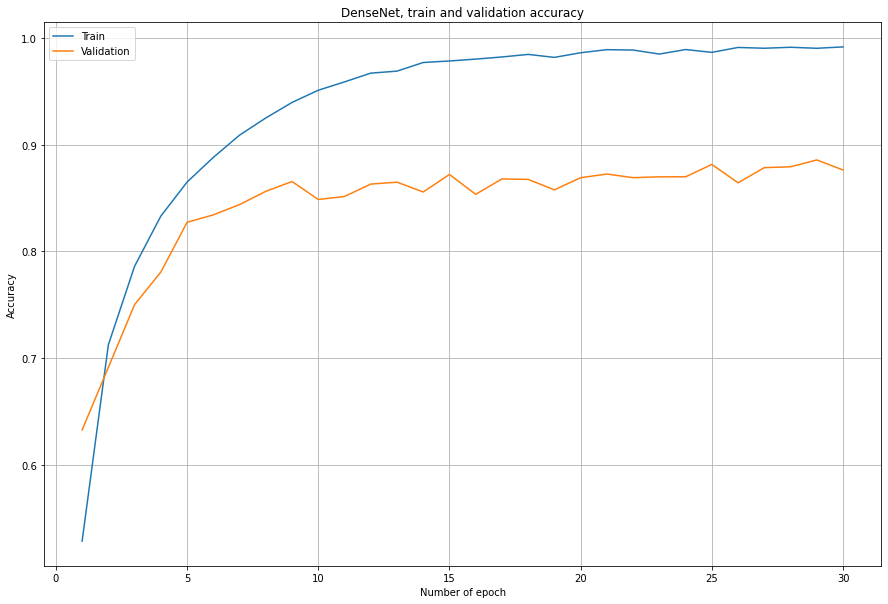

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('DenseNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9914222222222222, on 30 epoch
Best accuracy on validation: 0.8856, on 29 epoch


Точность на валидационной выборке еще до 10 эпохи превзошла значение 0.85, далее ее значения продолжают расти.

Качество DenseNet оказалась наилучшим среди рассмотренных архитектур. Таким образом, применяемые в ней идеи действительно положительно влияют на качество классификации и позволяют эффективно обучать глубокие сети. Однако время обучения довольно велико.

# EfficientNet

Данная архитектура относится к т. н. мобильным архитектурам. EfficientNet создавалсь для эффективного масштабирования сети, т. е. сбалансированного изменения глубины, разрешения и числа каналов для повышения качества и эффективности сети. Эта задача представляется как задача условной максимизации качества при ограничениях на число операций с плавающей точкой и объем памяти. Оптимизация идет по 3 параметрам, отвечающим за глубину, число каналов признаков и размеры каждого канала. Эти параметры представляются как заданные коэффициенты в степени с одинаковым показателем, и максимизация проводится по этому показателю для оптимизации по глубине, числу каналов и их размерам в совокупности, а не по отдельности. В результате экспериментов обнаружилось, что такой процесс сбалансированной настройки позволяет облегчить архитектуру и получать наиболее важные участки для обработки, тем самым повышая качество. Таким образом, соблюдается баланс между сложностью и точностью. В качестве функции активации применяется swish.

In [32]:
def swish(x):
    return x * x.sigmoid()


def drop_connect(x, drop_ratio):
    keep_ratio = 1.0 - drop_ratio
    mask = torch.empty([x.shape[0], 1, 1, 1], dtype=x.dtype, device=x.device)
    mask.bernoulli_(keep_ratio)
    x.div_(keep_ratio)
    x.mul_(mask)
    return x


class SE(nn.Module):
    

    def __init__(self, in_channels, se_channels):
        super(SE, self).__init__()
        self.se1 = nn.Conv2d(in_channels, se_channels,
                             kernel_size=1, bias=True)
        self.se2 = nn.Conv2d(se_channels, in_channels,
                             kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1))
        out = swish(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out
        return out


class Block(nn.Module):
    

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 expand_ratio=1,
                 se_ratio=0.,
                 drop_rate=0.):
        super(Block, self).__init__()
        self.stride = stride
        self.drop_rate = drop_rate
        self.expand_ratio = expand_ratio

        
        channels = expand_ratio * in_channels
        self.conv1 = nn.Conv2d(in_channels,
                               channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        
        self.conv2 = nn.Conv2d(channels,
                               channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=(1 if kernel_size == 3 else 2),
                               groups=channels,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        
        se_channels = int(in_channels * se_ratio)
        self.se = SE(channels, se_channels)

        
        self.conv3 = nn.Conv2d(channels,
                               out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        
        self.has_skip = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        out = x if self.expand_ratio == 1 else swish(self.bn1(self.conv1(x)))
        out = swish(self.bn2(self.conv2(out)))
        out = self.se(out)
        out = self.bn3(self.conv3(out))
        if self.has_skip:
            if self.training and self.drop_rate > 0:
                out = drop_connect(out, self.drop_rate)
            out = out + x
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(cfg['out_channels'][-1], num_classes)

    def _make_layers(self, in_channels):
        layers = []
        cfg = [self.cfg[k] for k in ['expansion', 'out_channels', 'num_blocks', 'kernel_size',
                                     'stride']]
        b = 0
        blocks = sum(self.cfg['num_blocks'])
        for expansion, out_channels, num_blocks, kernel_size, stride in zip(*cfg):
            strides = [stride] + [1] * (num_blocks - 1)
            for stride in strides:
                drop_rate = self.cfg['drop_connect_rate'] * b / blocks
                layers.append(
                    Block(in_channels,
                          out_channels,
                          kernel_size,
                          stride,
                          expansion,
                          se_ratio=0.25,
                          drop_rate=drop_rate))
                in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        dropout_rate = self.cfg['dropout_rate']
        if self.training and dropout_rate > 0:
            out = F.dropout(out, p=dropout_rate)
        out = self.linear(out)
        return out


def EfficientNetB0():
    cfg = {
        'num_blocks': [1, 2, 2, 3, 3, 4, 1],
        'expansion': [1, 6, 6, 6, 6, 6, 6],
        'out_channels': [16, 24, 40, 80, 112, 192, 320],
        'kernel_size': [3, 3, 5, 3, 5, 5, 3],
        'stride': [1, 2, 2, 2, 1, 2, 1],
        'dropout_rate': 0.2,
        'drop_connect_rate': 0.2,
    }
    return EfficientNet(cfg)


Рассмотрим простейшую архитектуру из данного семейства - EfficientNetB0.

In [33]:
count_parameters(EfficientNetB0())

3599686

In [ ]:
%%time
model = EfficientNetB0()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 22min 14s, sys: 1min 2s, total: 23min 16s
Wall time: 23min 23s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'EfficientNet, test loss: {loss}')
print(f'EfficientNet, test accuracy: {acc}')

EfficientNet, test loss: 1.1476956605911255
EfficientNet, test accuracy: 0.7754
CPU times: user 4.02 s, sys: 5.18 ms, total: 4.02 s
Wall time: 4.02 s


EfficientNet быстро обучается, однако качество на тестовых данных ниже, чем у большинства остальных моделей. 

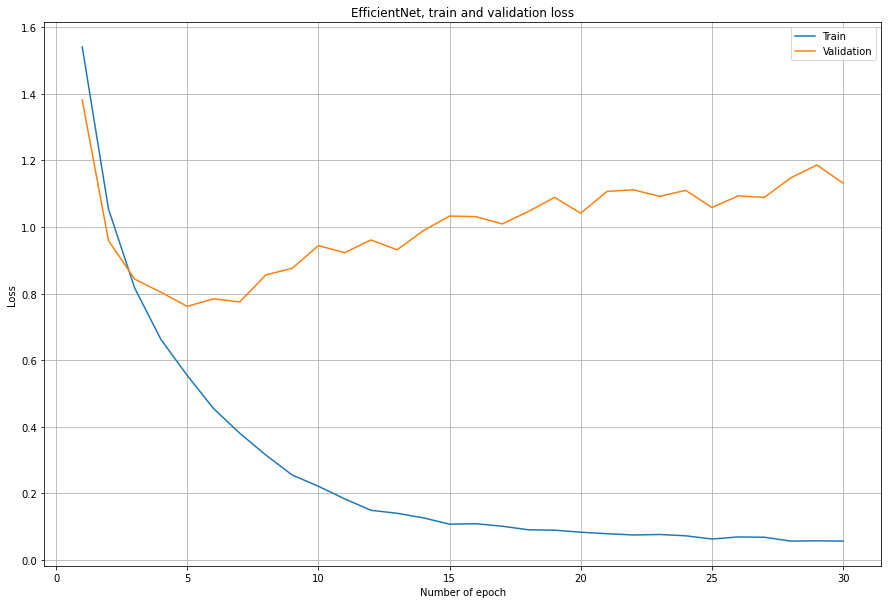

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('EfficientNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.0567624463862843, on 28 epoch
Best loss on validation: 0.7614505290985107, on 5 epoch


Потери на валидации высоки, наблюдается их рост с 5 эпохи, присутствует переобучение.

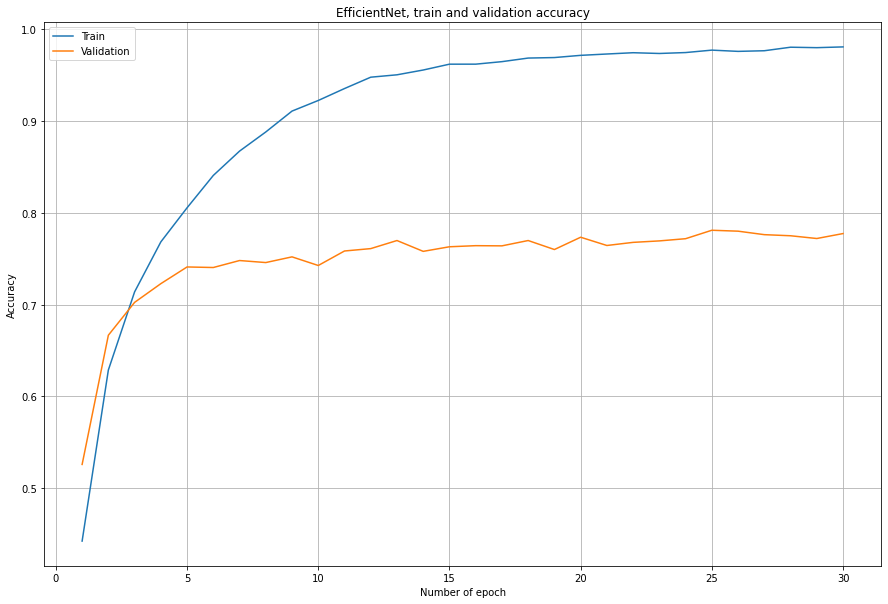

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('EfficientNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9808, on 30 epoch
Best accuracy on validation: 0.781, on 25 epoch


График точности весьма стабилен и плавно возрастает.

EfficientNet довольно быстро обучается и имеет малое число параметров, однако ее точность сравнима с AlexNet. В целом качество этой архитектуры можно считать приемлемым.

# MobileNet

Основная цель создания этой архитектуры - максимальное уменьшение числа параметров и требований к вычислительным мощностям. В ней применяются depthwise separable convolutions: каждый канал входного тензора обрабатывается своим ядром свертки, а далее применяются свертки 1$\times$1. Это сокращает число параметров и увеличивает быстродейтсвие сети. Также вместо max pooling используются свертки с шагом 2. В качестве функции активации применяется ReLU6. Она вычисляется проще сигмоиды и похожа на нее по форме.

In [5]:
class Block(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu6(self.bn1(self.conv1(x)))
        out = F.relu6(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu6(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [6]:
count_parameters(MobileNet())

3217226

In [ ]:
%%time
model = MobileNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 13min 2s, sys: 1.89 s, total: 13min 4s
Wall time: 13min 7s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'MobileNet, test loss: {loss}')
print(f'MobileNet, test accuracy: {acc}')

MobileNet, test loss: 1.1934185028076172
MobileNet, test accuracy: 0.7458
CPU times: user 3.41 s, sys: 2.59 ms, total: 3.42 s
Wall time: 3.43 s


Сеть действительно быстро обучается, однако точность на тесте невысокая.

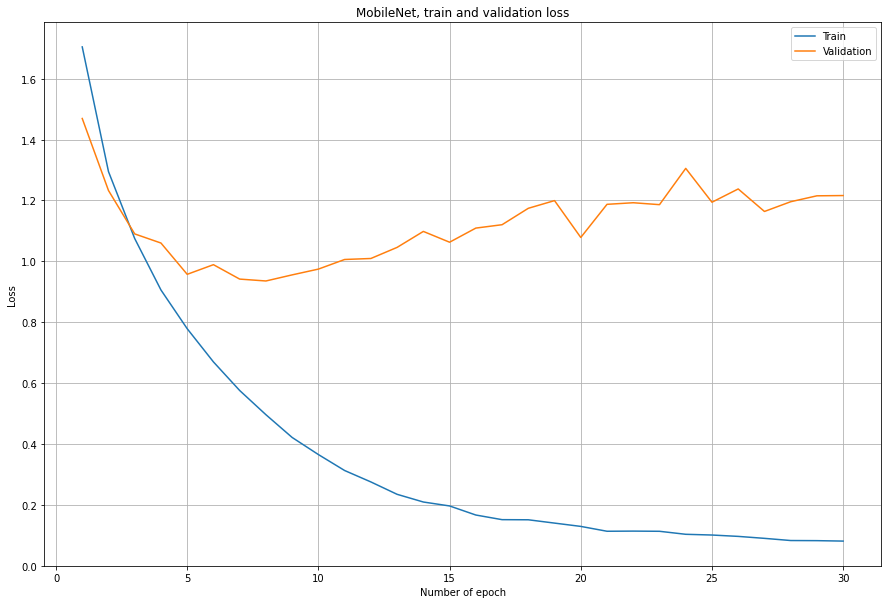

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('MobileNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.08105271794067488, on 30 epoch
Best loss on validation: 0.9354987144470215, on 8 epoch


Потери на валидации достаточно велики и рано начинают расти.

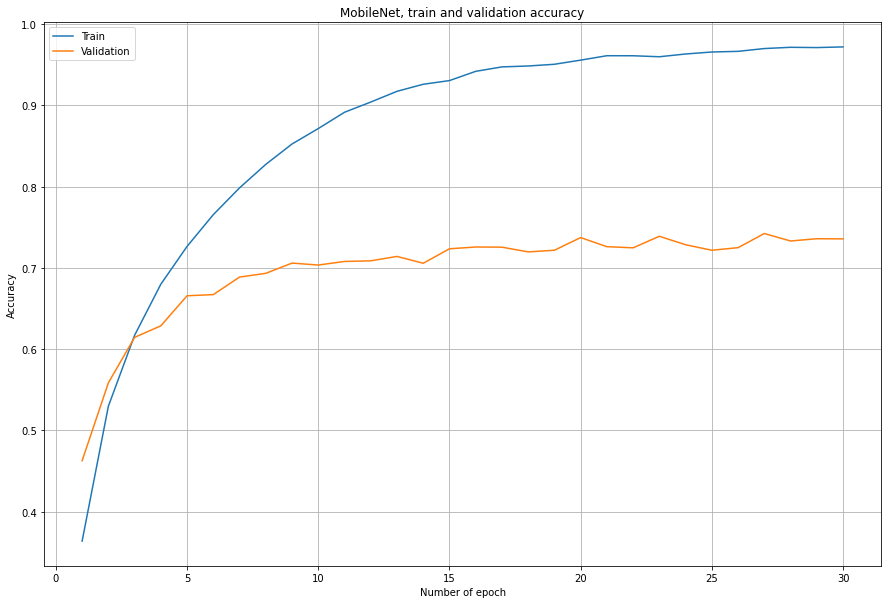

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('MobileNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9720666666666666, on 30 epoch
Best accuracy on validation: 0.7424, on 27 epoch


Качество на протяжении обучения не превосходит 0.75, плавно растет с ростом номера эпохи.

MobileNet является легкой и быстрой архитектурой, но итоговое качество является невысоким. Результаты чуть хуже, чем у EfficientNet.

# ShuffleNet

Используется идея групповых сверток с перемешиванием каналов. Перемешивание позволяет распределить части каналов для учета информации, локализованной по группам, повысить разнообразие обрабатываемых признаков. Групповые свертки помогают уменьшить сложность архитектуры. 

Рассмотрим два варианта архитектуры: ShuffleNetG2 и ShuffleNetG3. Они отличаются числом групп каналов и параметрами сверточных слоев.

In [20]:
class ShuffleBlock(nn.Module):
    def __init__(self, groups):
        super(ShuffleBlock, self).__init__()
        self.groups = groups

    def forward(self, x):
        '''Channel shuffle: [N,C,H,W] -> [N,g,C/g,H,W] -> [N,C/g,g,H,w] -> [N,C,H,W]'''
        N,C,H,W = x.size()
        g = self.groups
        return x.view(N,g,C//g,H,W).permute(0,2,1,3,4).reshape(N,C,H,W)


class Bottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, stride, groups):
        super(Bottleneck, self).__init__()
        self.stride = stride

        mid_planes = out_planes//4
        g = 1 if in_planes==24 else groups
        self.conv1 = nn.Conv2d(in_planes, mid_planes, kernel_size=1, groups=g, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_planes)
        self.shuffle1 = ShuffleBlock(groups=g)
        self.conv2 = nn.Conv2d(mid_planes, mid_planes, kernel_size=3, stride=stride, padding=1, groups=mid_planes, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_planes)
        self.conv3 = nn.Conv2d(mid_planes, out_planes, kernel_size=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 2:
            self.shortcut = nn.Sequential(nn.AvgPool2d(3, stride=2, padding=1))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.shuffle1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        res = self.shortcut(x)
        out = F.relu(torch.cat([out,res], 1)) if self.stride==2 else F.relu(out+res)
        return out


class ShuffleNet(nn.Module):
    def __init__(self, cfg):
        super(ShuffleNet, self).__init__()
        out_planes = cfg['out_planes']
        num_blocks = cfg['num_blocks']
        groups = cfg['groups']

        self.conv1 = nn.Conv2d(3, 24, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.in_planes = 24
        self.layer1 = self._make_layer(out_planes[0], num_blocks[0], groups)
        self.layer2 = self._make_layer(out_planes[1], num_blocks[1], groups)
        self.layer3 = self._make_layer(out_planes[2], num_blocks[2], groups)
        self.linear = nn.Linear(out_planes[2], 10)

    def _make_layer(self, out_planes, num_blocks, groups):
        layers = []
        for i in range(num_blocks):
            stride = 2 if i == 0 else 1
            cat_planes = self.in_planes if i == 0 else 0
            layers.append(Bottleneck(self.in_planes, out_planes-cat_planes, stride=stride, groups=groups))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ShuffleNetG2():
    cfg = {
        'out_planes': [200,400,800],
        'num_blocks': [4,8,4],
        'groups': 2
    }
    return ShuffleNet(cfg)

def ShuffleNetG3():
    cfg = {
        'out_planes': [240,480,960],
        'num_blocks': [4,8,4],
        'groups': 3
    }
    return ShuffleNet(cfg)

**ShuffleNetG2**

ShuffleNet имеет действительно малое число параметров.

In [4]:
count_parameters(ShuffleNetG2())

887582

In [ ]:
%%time
model = ShuffleNetG2()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 31min 2s, sys: 9min 44s, total: 40min 46s
Wall time: 41min 4s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'ShuffleNet, test loss: {loss}')
print(f'ShuffleNet, test accuracy: {acc}')

ShuffleNet, test loss: 1.2193809747695923
ShuffleNet, test accuracy: 0.7567
CPU times: user 4.03 s, sys: 7.16 ms, total: 4.03 s
Wall time: 4.04 s


Время обучения мало, качество сравнимо с остальными мобильными архитектурами.

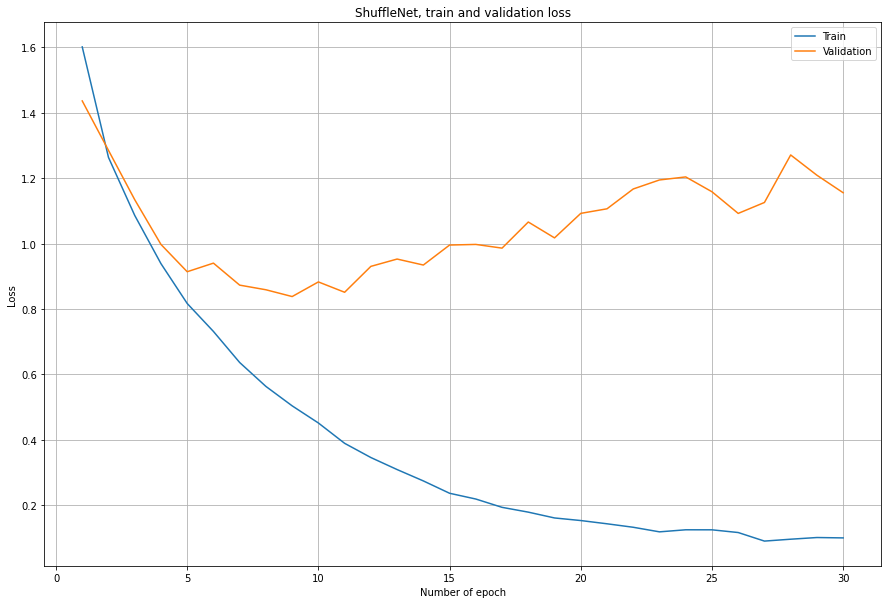

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ShuffleNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.08964202045798302, on 27 epoch
Best loss on validation: 0.8378129005432129, on 9 epoch


Есть заметный рост потерь на валидации в процессе обучения, присутствует переобучение.

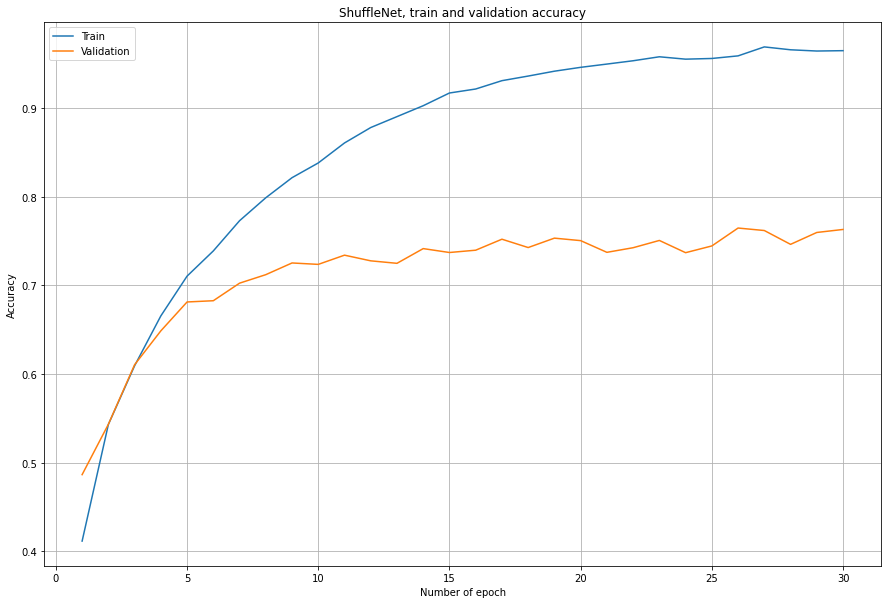

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ShuffleNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9691333333333333, on 27 epoch
Best accuracy on validation: 0.7648, on 26 epoch


Качество приемлемо, но не высоко, есть небольшой стабильный рост точности на валидации.

**ShuffleNetG3**

Меньшее число параметров - только у LeNet.

In [21]:
count_parameters(ShuffleNetG3())

862768

In [ ]:
%%time
model = ShuffleNetG3()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 30min 21s, sys: 13min 24s, total: 43min 45s
Wall time: 43min 54s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'ShuffleNet, test loss: {loss}')
print(f'ShuffleNet, test accuracy: {acc}')

ShuffleNet, test loss: 1.1971303224563599
ShuffleNet, test accuracy: 0.7515
CPU times: user 3.71 s, sys: 3.83 ms, total: 3.71 s
Wall time: 3.72 s


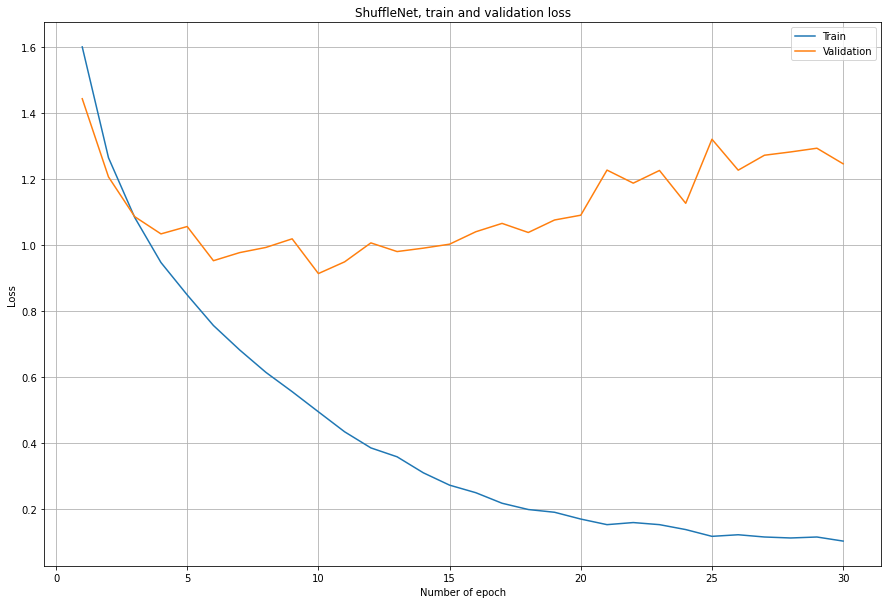

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ShuffleNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.10426964725719558, on 30 epoch
Best loss on validation: 0.9133869409561157, on 10 epoch


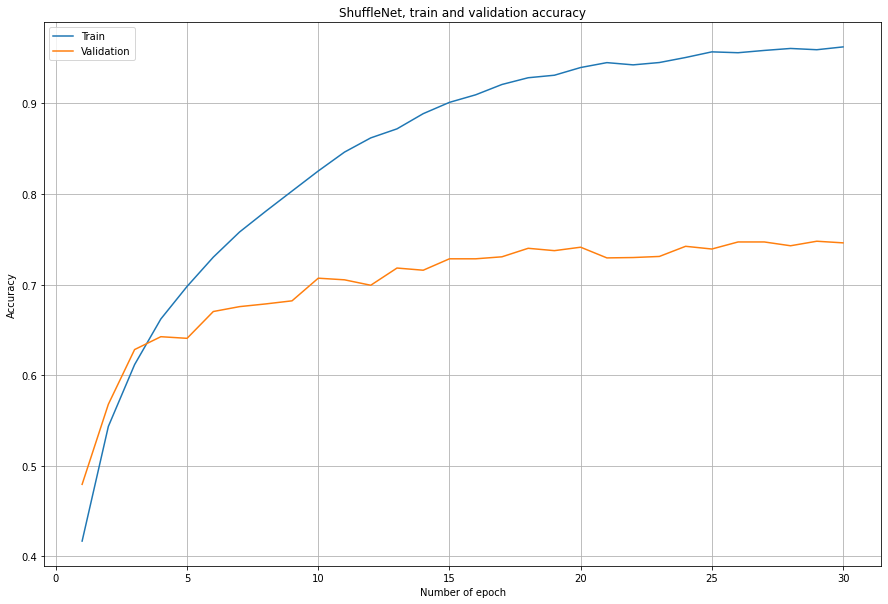

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('ShuffleNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9623333333333334, on 30 epoch
Best accuracy on validation: 0.7478, on 29 epoch


Результаты ShuffleNetG3 не сильно отличаются от ShuffleNetG2 и остальных мобильных архитектур.

# SENet

Основным нововведением SENet стала адаптивная перекалибровка каналов. Применяется global average pooling, получается одномерный вектор длины, равной числу каналов. После он по сути пропускается через отдельную небольшую нейросеть из линейного слоя, ReLU, второго линейного слоя и сигмоиды. Ее выходом будет вектор той же размерности. Далее каждый канал исходного тензора домножается на соответствующую компоненту полученного вектора. Таким образом, происходит перевзвешивание каналов в соответствии с их важностью. Это позволяет учитывать межканальные зависимости и проводить автоматическую селекцию каналов, что влечет к увеличению функциональной выразимости сети.

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)  
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        out = out * w  

        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
            )

    
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))

        
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))

        out = out * w

        out += shortcut
        return out


class SENet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SENet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def SENet18():
    return SENet(PreActBlock, [2,2,2,2])


In [8]:
count_parameters(SENet18())

11260354

In [ ]:
%%time
model = SENet18()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CPU times: user 25min 32s, sys: 55.1 s, total: 26min 27s
Wall time: 26min 40s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'SENet, test loss: {loss}')
print(f'SENet, test accuracy: {acc}')

SENet, test loss: 0.8097237944602966
SENet, test accuracy: 0.8511
CPU times: user 5.41 s, sys: 4.62 ms, total: 5.42 s
Wall time: 5.43 s


Модель достаточно быстро обучается и достигает высокого качества на тесте. 

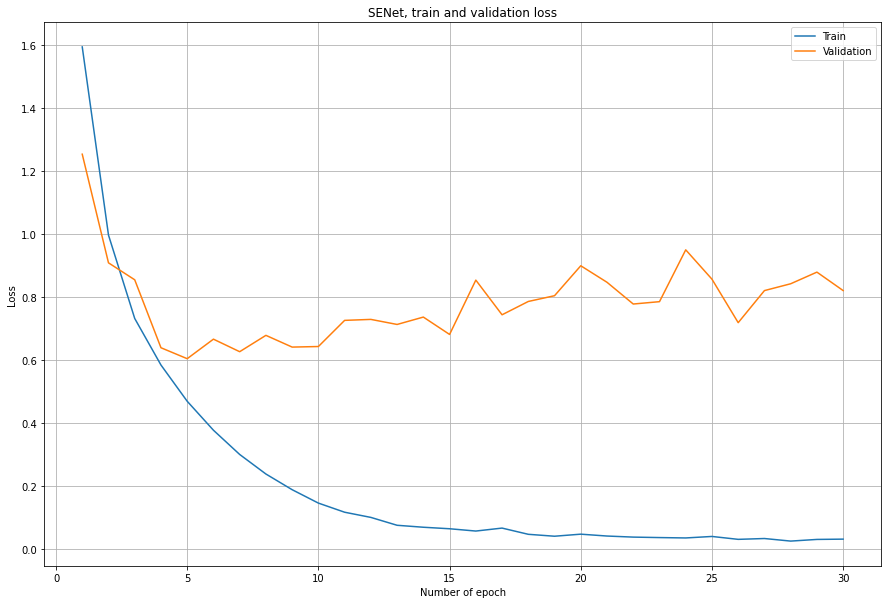

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('SENet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.024170023106245532, on 28 epoch
Best loss on validation: 0.6033918261528015, on 5 epoch


Потери на валидации начинают расти рано и достаточно резко, график нестабильный.

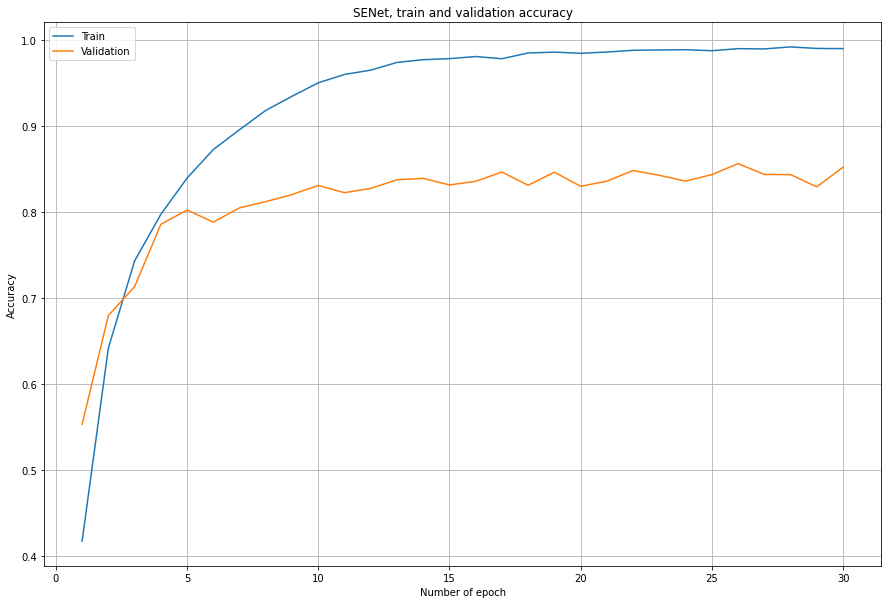

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('SENet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9918444444444444, on 28 epoch
Best accuracy on validation: 0.8562, on 26 epoch


Качество же весьма высокое и медленно растет с ростом числа эпох.

SENet имеет одно из лучших значений точности на тестовых данных, а также быстро обучается.

# WideResNet

Вместо увеличения глубины сети используется увеличиние ее ширины, т. е. числа каналов. За основу берется ResNet-блок. Увеличивается число фильтров в сверточном слое. Это регулируется параметром k, на который домножается число фильтров. Такой прием привел к улучшению качества архитектуры и снижению эффекта переобучения по сравнению с ResNet. Также используются дропаут и батч-нормализация.

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))

        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

    @staticmethod
    def _make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth=28, num_classes=10, widen_factor=10, drop_rate=0.0):
        super(WideResNet, self).__init__()
        n_channels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = int((depth - 4) / 6)
        block = BasicBlock
    
        self.conv1 = nn.Conv2d(3, n_channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        
        self.block1 = NetworkBlock(n, n_channels[0], n_channels[1], block, 1, drop_rate)
        
        self.block2 = NetworkBlock(n, n_channels[1], n_channels[2], block, 2, drop_rate)
        
        self.block3 = NetworkBlock(n, n_channels[2], n_channels[3], block, 2, drop_rate)
        
        self.bn1 = nn.BatchNorm2d(n_channels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(n_channels[3], num_classes)
        self.nChannels = n_channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [11]:
count_parameters(WideResNet())

36479194

In [ ]:
%%time
model = WideResNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 1h 52min 18s, sys: 14min 40s, total: 2h 6min 59s
Wall time: 2h 7min 53s


In [ ]:
%%time
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'WideResNet, test loss: {loss}')
print(f'WideResNet, test accuracy: {acc}')

WideResNet, test loss: 0.7140601873397827
WideResNet, test accuracy: 0.8602
CPU times: user 21.3 s, sys: 44.8 ms, total: 21.3 s
Wall time: 21.4 s


Время работы WideResNet очень велико, однако точность на тесте - одна из самых высоких.

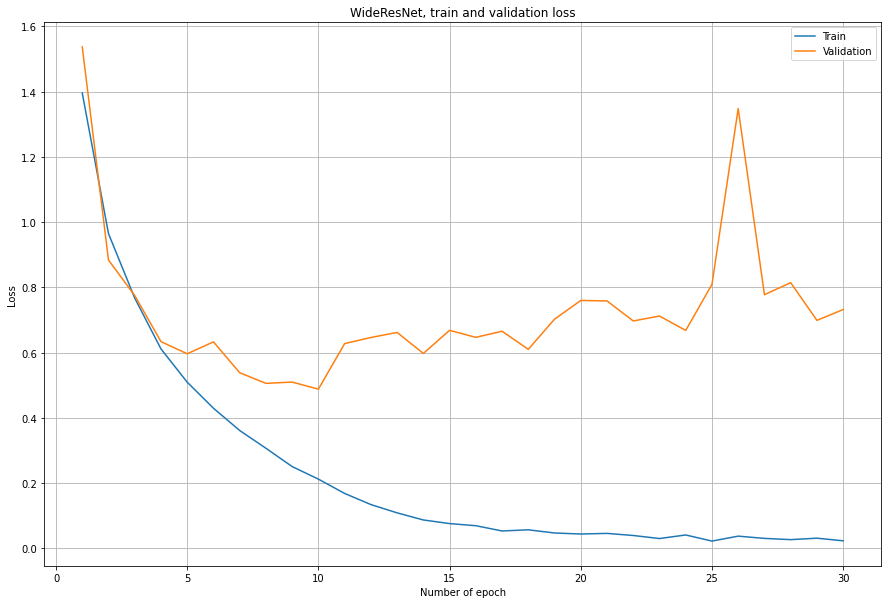

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('WideResNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

Best loss on train: 0.021729397925237814, on 25 epoch
Best loss on validation: 0.4875830113887787, on 10 epoch


Присутствует небольшой рост потерь на валидационной выборке, а также наблюдается сильный скачок графика ближе к финальным эпохам.

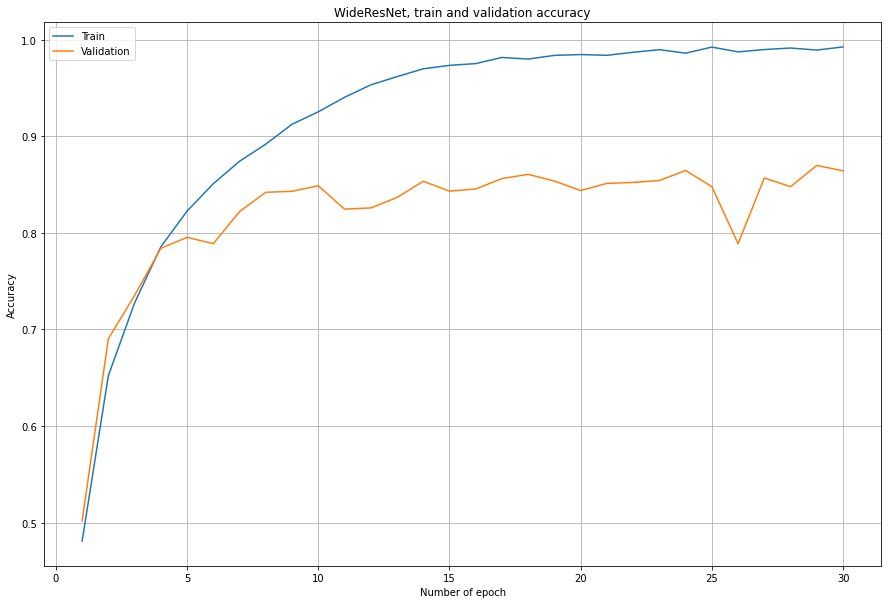

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('WideResNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')

Best accuracy on train: 0.9924888888888889, on 30 epoch
Best accuracy on validation: 0.8698, on 29 epoch


Качество достаточно высокое, и его спада к концу обучения не наблюдается.

# Результаты

Приведем результаты для всех рассмотренных архитектур в следующих таблицах:

|  Архитектура | Число параметров | Время обучения  | Время предсказания | Потери на тесте | Точность на тесте |
|--------------|------------------|-----------------|--------------------|-----------------|-------------------|
| **LeNet**        | 62006            | 8 мин 23 с      | 2.77 с             | 1.4857          | 0.5529            |
| **AlexNet**      | 23272266         | 10 мин 18 c     | 3.08 с             | 1.71006         | 0.6978            |
| **VGG11**        | 9231114          | 9 мин 51 c      | 2.54 с             | 1.01743         | 0.8216            |
| **VGG13**        | 9416010          | 12 мин 28 с     | 2.85 с             | 0.8276          | 0.8437            |
| **VGG16**        | 14728266         | 13 мин 50 с     | 3.15 с             | 0.70857         | 0.8575            |
| **VGG19**        | 20040522         | 17 мин 5 с      | 4.12 с             | 0.77653         | 0.8493            |
| **GoogLeNet**    | 6166250          | 1 ч 12 мин 44 с | 12.4 с             | 0.80697         | 0.8427            |
| **ResNet18**     | 11173962         | 21 мин 50 с     | 4.21 с             | 1.04602         | 0.823             |
| **ResNet34**     | 21282122         | 32 мин 58 с     | 5.85 с             | 0.8527          | 0.8373            |
| **ResNet50**     | 23520842         | 54 мин 25 с     | 9.25 с             | 0.80213         | 0.8383            |
| **ResNet101**    | 42512970         | 1 ч 16 мин 58 с | 11.6 с             | 0.86527         | 0.8211            |
| **DenseNet**     | 6956298          | 1 ч 5 мин 36 с  | 10.2 с             | 0.6323          | **0.8775**            |
| **EfficientNet** | 3599686          | 23 мин 23 с     | 4.02 с             | 1.14765         | 0.7754            |
| **MobileNet**    | 3217226          | 13 мин 7 с      | 3.43 с             | 1.19341         | 0.7458            |
| **ShuffleNetG2** | 887582           | 41 мин 4 с      | 4.04 с             | 1.21938         | 0.7567            |
| **ShuffleNetG3** | 862768           | 43 мин 54 с     | 3.72 с             | 1.19713         | 0.7515            |
| **SENet**        | 11260354         | 26 мин 40 с     | 5.43 с             | 0.80972         | 0.8511            |
| **WideResNet**   | 36479194         | 2 ч 7 мин 53 с  | 21.4 с             | 0.71406         | 0.8602            |

|  Архитектура | Лучший лосс, обучение | Лучший лосс, валидация | Лучшая точность, обучение | Лучшая точность, валидация |
|--------------|-----------------------|------------------------|---------------------------|----------------------------|
| **LeNet**        | 0.649, 30 эпоха       | 1.273, 11 эпоха        | 0.77064, 30 эпоха         | 0.5634, 17 эпоха           |
| **AlexNet**      | 0.10551, 30 эпоха     | 0.90208, 7 эпоха       | 0.96604, 30 эпоха         | 0.71, 29 эпоха             |
| **VGG11**        | 0.02102, 30 эпоха     | 0.61185, 5 эпоха       | 0.99304, 30 эпоха         | 0.8348, 28 эпоха           |
| **VGG13**        | 0.02422, 28 эпоха     | 0.54706, 8 эпоха       | 0.992, 28 эпоха           | 0.8566, 19 эпоха           |
| **VGG16**        | 0.02554, 29 эпоха     | 0.51084, 8 эпоха       | 0.99171, 29 эпоха         | 0.8584, 28 эпоха           |
| **VGG19**        | 0.04085, 27 эпоха     | 0.56164, 9 эпоха       | 0.98784, 27 эпоха         | 0.8516, 28 эпоха           |
| **GoogLeNet**    | 0.0242, 29 эпоха      | 0.45666, 8 эпоха       | 0.99137, 29 эпоха         | 0.8732, 26 эпоха           |
| **ResNet18**     | 0.0177, 26 эпоха      | 0.5827, 7 эпоха        | 0.99378, 26 эпоха         | 0.8466, 25 эпоха           |
| **ResNet34**     | 0.01365, 28 эпоха     | 0.54725, 8 эпоха       | 0.99508, 28 эпоха         | 0.851, 30 эпоха            |
| **ResNet50**     | 0.02959, 27 эпоха     | 0.59598, 9 эпоха       | 0.99067, 27 эпоха         | 0.8458, 15 эпоха           |
| **ResNet101**    | 0.02798, 27 эпоха     | 0.54524, 10 эпоха      | 0.991, 27 эпоха           | 0.8416, 22 эпоха           |
| **DenseNet**     | 0.02433, 30 эпоха     | 0.42726, 9 эпоха       | 0.99141, 30 эпоха         | 0.8856, 29 эпоха           |
| **EfficientNet** | 0.05676, 28 эпоха     | 0.76145, 5 эпоха       | 0.9808, 30 эпоха          | 0.781, 25 эпоха            |
| **MobileNet**    | 0.08105, 30 эпоха     | 0.93549, 8 эпоха       | 0.97206, 30 эпоха         | 0.7424, 27 эпоха           |
| **ShuffleNetG2** | 0.08964, 27 эпоха     | 0.83781, 9 эпоха       | 0.96913, 27 эпоха         | 0.7648, 26 эпоха           |
| **ShuffleNetG3** | 0.10426, 30 эпоха     | 0.91338, 10 эпоха      | 0.96239, 30 эпоха         | 0.7478, 29 эпоха           |
| **SENet**        | 0.02417, 28 эпоха     | 0.60339, 5 эпоха       | 0.99184, 28 эпоха         | 0.8562, 26 эпоха           |
| **WideResNet**   | 0.02173, 25 эпоха     | 0.48758, 10 эпоха      | 0.99248, 30 эпоха         | 0.8698, 29 эпоха           |

Наилучшая точность на тестовой выборке - у архитектуры **DenseNet: 0.8775**. Это качество является довольно высоким. У нее же и наименьшее значение функции потерь на тесте: **0.6323**. Однако время обучения и предсказания у данной сети - одни из самых больших: **1 ч 5 мин 36 с** и **10.2 c** соответственно.

Вторая после DenseNet - **WideResNet** с точностью **0.8602** и потерями **0.7146**. При этом она имеет самое долгое время работы, обучение заняло **2 ч 7 мин 53 с**, время построения прогноза - **21.4c**.

На третьем месте - **VGG16**. Итоговая точность - **0.8575**, потери - **0.70857**. Обучается и работает данная архитектура куда быстрее предыдущих двух: **13 мин 50 с** и **3.15 c** соответственно. Причиной весьма высоких результатов может являться использование модифицированной реализации сети, с батч-нормализацией и упрощенной частью классификации.

Также хорошие результаты демонстрируют архитектуры ResNet и VGG. Они имеют высокую точность (около 0.82 - 0.85) и относительно небольшое время обучения (кроме ResNet50 и ResNet101). При этом для архитектур VGG точность на тесте в среднем немного выше, но время обучения - существенно меньше. 

Незначительно худшие результаты имеют SENet и GoogLeNet, причем SENet лидирует как по точности, так и по времени работы. 

Мобильные архитектуры EfficientNet, ShuffleNet, MobileNet не достигают высокого качества, однако быстро обучаются. В целом при их легковесности и быстродействии точность около 0.7 - 0.75 можно считать приемлемой. Возможно, на их качество могло повлиять и использование других функций активации.

Простейшие архитектуры LeNet и AlexNet плохо справляются с задачей, качество на валидации и тесте крайне низкое, хотя AlexNet отчасти близка по результатам к мобильным архитектурам.

В целом наилучшими с точки зрения оптимального сочетания высокой точности и быстрой работы можно считать **VGG16** и **SENet**. У них также не наблюдается заметного переобучения и падения точности на валидации, а также они имеют простую реализацию и базируются на относительно простых принципах.

Стоит отметить, что на итоговые результаты для всех архитектур влияет большое число факторов: данные, их разделение на обучающую, валидационную и тестовую выборки, метод обучения сети и его параметры, особенности использованных реализаций архитектур, размер батча, число эпох обучения и т. п. При ином дизайне экспериментов результат может заметно отличаться от полученного в данной работе. К примеру, при экспериментах с меньшим значением темпа обучения, с постепенным его убыванием или с другим оптимизатором точность моделей была значительно хуже, чем в данной конфигурации. 